In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Datasets/2payments_balanced_smote+rund-10m.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [25, 26]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 5,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = 0.001,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = 5,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate 
        min_alpha = 0.001,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])
    
    return model

In [15]:
curr_model = training(sentences_series_np_train)

Validation loss decreased (inf --> 112866.812500).  Saving model ...
Validation loss decreased (112866.812500 --> 58461.546875).  Saving model ...
Validation loss decreased (58461.546875 --> 54259.859375).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (54259.859375 --> 47403.218750).  Saving model ...
Validation loss decreased (47403.218750 --> 45974.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (45974.687500 --> 41839.812500).  Saving model ...
Validation loss decreased (41839.812500 --> 41236.812500).  Saving model ...
Validation loss decreased (41236.812500 --> 39972.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (39972.250000 --> 38919.687500).  Saving model ...
Validation loss decreased (38919.687500 --> 38151.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (

In [16]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [17]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.append(curr_prob)

    return predictions, predictions_prob

In [18]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [19]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [20]:
#call predictions
prevs, prevs_prob = predict(curr_model, sentences_series_np_test, verbose1 = True, verbose2 = True)

['mbp', 'pagsrv', 'c2102117', 'e61', 'r4355526', 'ntrusted', 'io1015636', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip1434615862', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 514, 23779, 0, 23780, 1, 21, 8, 40, 23781, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0011873301245941548
Non Fraud prob: 0.001167440341305337
['mbp', 'pagsrv', 'c2030577', 'e525', 'r8472413', 'ntrusted', 'io5311169', 'id3', 'apbink', 'nfraud', 'darbec', 'ip8719680244', 'other', 'android', 'dawn', 'w48', 'tue', 'nov', 'ttablet']
Transaction: [9, 2, 105, 23783, 0, 23784, 1, 64, 7, 30, 23785, 13, 11, 78, 61, 33, 35, 14]
Fraud prob: 0.00097311969511793
Non Fraud prob: 0.0009698035446490394
['mbp', 'pagsrv', 'c3539202', 'e5846', 'r11174744', 'ntrusted', 'io677426', 'id3', 'kapin', 'nfraud', 'arbed', 'ip959318062', 'safari', 'ios', 'dusk', 'w2', 'sun', 'jan', 'tmobile']
Transaction: [9, 2, 556, 23787, 0, 23788, 1, 65, 7, 46, 23789, 34, 42, 24, 117, 60, 43, 36]
Fraud prob: 0.0007918724495539209

Transaction: [9, 2, 25, 23865, 0, 90, 1, 27, 8, 18, 23866, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945325065452303
Non Fraud prob: 0.8945325065452303
['mbp', 'pagsrv', 'c2105029', 'e469', 'r14715270', 'ntrusted', 'io1688088', 'id3', 'pink', 'nfraud', 'darbec', 'ip79169102199', 'other', 'android', 'dusk', 'w13', 'wed', 'mar', 'ttablet']
Transaction: [9, 2, 25, 23868, 0, 23869, 1, 217, 7, 30, 23870, 13, 11, 24, 113, 26, 20, 14]
Fraud prob: 0.0009189414467982715
Non Fraud prob: 0.00091497834182519
['mbp', 'pagsrv', 'c2647358', 'e117', 'r11292431', 'ntrusted', 'io2647359', 'id3', 'bicnkap', 'fraud', 'cdarbe', 'ip1709264918', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 291, 23872, 0, 23873, 1, 58, 8, 28, 23874, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0013562167787313228
Non Fraud prob: 0.001346159317108686
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8640292', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morni

Transaction: [16, 57, 82, 23935, 0, 23936, 1, 65, 7, 30, 23937, 6, 4, 19, 102, 26, 12, 3]
Fraud prob: 0.0012170358295406913
Non Fraud prob: 0.0012165461102995323
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14039584', 'ntrusted', 'io698878', 'id3', 'pbinka', 'fraud', 'ecdarb', 'ip8719680190', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 14595, 0, 53, 1, 38, 8, 18, 132, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945325086028876
Non Fraud prob: 0.8945325086028876
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14165883', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672152', 'other', 'android', 'night', 'w11', 'sat', 'mar', 'ttablet']
Transaction: [9, 2, 25, 133, 0, 53, 1, 27, 8, 18, 104, 13, 11, 47, 37, 54, 20, 14]
Fraud prob: 0.89453251461998
Non Fraud prob: 0.89453251461998
['nbe', 'pagsrv', 'c825611', 'e37', 'r8638488', 'ntrusted', 'io825613', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip8524729224', 'chrome', 'windows', 'morning', 'w48',

Transaction: [16, 2, 368, 24006, 73, 24007, 1, 27, 7, 29, 24008, 6, 4, 24, 61, 54, 35, 3]
Fraud prob: 0.0017957348136405926
Non Fraud prob: 0.001756572619342478
['nbe', 'pagsrv', 'c1528134', 'e5623', 'r7972925', 'ntrusted', 'io7972548', 'id3', 'icnkapb', 'fraud', 'becdar', 'ip1094823580', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 69, 24010, 0, 24011, 1, 49, 8, 40, 24012, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0008245673993769742
Non Fraud prob: 0.0008265878527708992
['nbp', 'pagsrv', 'c4326813', 'e155', 'r12125839', 'ntrusted', 'io5374097', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrome', 'windows', 'morning', 'w5', 'fri', 'jan', 'pc']
Transaction: [16, 2, 89, 24013, 0, 161, 1, 92, 8, 40, 145, 6, 4, 5, 88, 23, 43, 3]
Fraud prob: 0.02347666057179407
Non Fraud prob: 0.02347666057179407
['mbp', 'pagsrv', 'c1862095', 'e469', 'r3091437', 'ntrusted', 'io1862097', 'id3', 'pbinka', 'nfraud', 'arbed', 'ip1486951248', 'other', 'android', 'dawn

Transaction: [16, 2, 31, 24081, 0, 24082, 1, 38, 7, 46, 24083, 6, 4, 19, 70, 26, 20, 3]
Fraud prob: 0.0018504108984700451
Non Fraud prob: 0.0018533651409882168
['nbp', 'pagtel', 'c4716341', 'e151', 'r8311860', 'tunknown', 'io4716343', 'id3', 'nkapi', 'nfraud', 'cdarbe', 'ip8911523010', 'edge', 'windows', 'afternoon', 'w22', 'wed', 'may', 'pc']
Transaction: [16, 41, 198, 24085, 224, 24086, 1, 39, 7, 28, 24087, 67, 4, 19, 98, 26, 12, 3]
Fraud prob: 0.0009890084447761183
Non Fraud prob: 0.0009887505702863564
['nbe', 'pagsrv', 'c859106', 'e37', 'r7868401', 'ntrusted', 'io7867628', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip1094823617', 'chrome', 'windows', 'morning', 'w46', 'fri', 'nov', 'pc']
Transaction: [17, 2, 31, 24088, 0, 312, 1, 21, 8, 40, 324, 6, 4, 5, 121, 23, 35, 3]
Fraud prob: 0.009116777995590072
Non Fraud prob: 0.009116778021922815
['nbe', 'pagsrv', 'c1388416', 'e37', 'r8951507', 'ntrusted', 'io1205267', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip83240164194', 'chrome', 'windows', '

Transaction: [17, 2, 240, 24156, 0, 24157, 1, 66, 7, 86, 24158, 6, 4, 24, 172, 22, 94, 3]
Fraud prob: 0.0010853471067093778
Non Fraud prob: 0.001072481241862988
['nbe', 'pagsrv', 'c1482385', 'e37', 'r7463040', 'ntrusted', 'io853913', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip182252192', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 31, 24160, 0, 24161, 1, 21, 8, 18, 24162, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0017043397274392191
Non Fraud prob: 0.0017030071685439907
['mbp', 'pagsrv', 'c15750905', 'e14286780', 'r17445414', 'ntrusted', 'io428190', 'id3', 'cnkapbi', 'fraud', 'darbec', 'ip7817404202', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 24164, 24165, 0, 24166, 1, 72, 8, 30, 24167, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007482843084289925
Non Fraud prob: 0.0007469754018529784
['nbp', 'pagsrv', 'c3225507', 'e5837', 'r5302868', 'trusted', 'io1486717', 'id3', 'binkap', 'nfraud', 'darbe', 'ip9592119244', 'chrome', 'wind

Transaction: [16, 2, 24243, 24244, 0, 24245, 1, 38, 7, 59, 24246, 6, 4, 24, 108, 22, 52, 3]
Fraud prob: 0.0009957059537555324
Non Fraud prob: 0.0009882120302791009
['nbe', 'pagsrv', 'c3089739', 'e359083', 'r9468509', 'ntrusted', 'io3089740', 'id3', 'apbink', 'nfraud', 'ecdarb', 'ip832402037', 'chrome', 'windows', 'afternoon', 'w50', 'tue', 'dec', 'pc']
Transaction: [17, 2, 11417, 24248, 0, 24249, 1, 64, 7, 18, 24250, 6, 4, 19, 109, 33, 32, 3]
Fraud prob: 0.0007041827093416941
Non Fraud prob: 0.000701573059814109
['nbp', 'pagsrv', 'c7789065', 'e67062', 'r12755832', 'ntrusted', 'io1026345', 'id3', 'kapbin', 'nfraud', 'arbed', 'ip931088580', 'edge', 'windows', 'dusk', 'w7', 'mon', 'feb', 'pc']
Transaction: [16, 2, 24252, 24253, 0, 24254, 1, 79, 7, 46, 24255, 67, 4, 24, 151, 10, 56, 3]
Fraud prob: 0.001092965449061012
Non Fraud prob: 0.001078570967365522
['nbe', 'pagsrv', 'c1084404', 'e525', 'r8437273', 'ntrusted', 'io1084406', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip21322170143', 'ie', 'w

Transaction: [9, 2, 25, 24326, 0, 53, 1, 27, 8, 18, 14250, 13, 11, 5, 15, 10, 20, 14]
Fraud prob: 0.8945325056213111
Non Fraud prob: 0.8945325056213111
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14196647', 'ntrusted', 'io698878', 'id3', 'pbinka', 'fraud', 'ecdarb', 'ip871967324', 'other', 'android', 'morning', 'w12', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 24327, 0, 53, 1, 38, 8, 18, 157, 13, 11, 5, 70, 10, 20, 14]
Fraud prob: 0.8945325056160596
Non Fraud prob: 0.8945325056160596
['mbp', 'pagsrv', 'c2224616', 'e8211', 'r2224617', 'ntrusted', 'io698205', 'id3', 'pbinka', 'nfraud', 'darbe', 'ip8719672193', 'safari', 'ios', 'morning', 'w36', 'mon', 'sep', 'tmobile']
Transaction: [9, 2, 249, 24329, 0, 24330, 1, 38, 7, 29, 24331, 34, 42, 5, 87, 10, 45, 36]
Fraud prob: 0.000769512209444656
Non Fraud prob: 0.0007754742091492517
['nbp', 'pagest', 'c3395133', 'e140', 'r5768751', 'ntrusted', 'io1124232', 'id3', 'kapbin', 'nfraud', 'darbe', 'ip94132154213', 'chrome', 'windows', 'morning', 

Transaction: [9, 2, 684, 24404, 0, 24405, 1, 21, 8, 28, 24406, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006470146672654664
Non Fraud prob: 0.0006549101599375717
['nbe', 'pagest', 'c1649999', 'e3', 'r13051689', 'ntrusted', 'io1650000', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip9462230130', 'edge', 'windows', 'morning', 'w8', 'mon', 'feb', 'pc']
Transaction: [17, 57, 55, 24408, 0, 24409, 1, 39, 7, 30, 24410, 67, 4, 5, 120, 10, 56, 3]
Fraud prob: 0.0011361822489561746
Non Fraud prob: 0.0011252036147197941
['nbe', 'pagsrv', 'c825611', 'e37', 'r8641287', 'ntrusted', 'io825613', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip8524729224', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 196, 0, 122, 1, 21, 8, 40, 123, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.03343334416092749
Non Fraud prob: 0.03343334416032179
['nbe', 'pagsrv', 'c9848480', 'e37', 'r9848481', 'ntrusted', 'io243676', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1094820445', 'chrome', 'windows', 'morning', 'w51',

Transaction: [9, 41, 68, 24472, 0, 24473, 1, 65, 7, 125, 24474, 13, 11, 5, 77, 22, 32, 14]
Fraud prob: 0.0009747476397024002
Non Fraud prob: 0.0009744775670696981
['mbp', 'pagsrv', 'c11424326', 'e15741', 'r11424327', 'ntrusted', 'io2680605', 'id3', 'inkap', 'nfraud', 'becdar', 'ip6228189234', 'safari', 'ios', 'dusk', 'w3', 'thu', 'jan', 'tmobile']
Transaction: [9, 2, 14897, 24476, 0, 24477, 1, 51, 7, 40, 24478, 34, 42, 24, 150, 22, 43, 36]
Fraud prob: 0.0016288374899886549
Non Fraud prob: 0.0016288778533635195
['nbp', 'pagsrv', 'c3840682', 'e791', 'r10968858', 'ntrusted', 'io2353752', 'id3', 'nkapbic', 'fraud', 'darbec', 'ip188250138250', 'chrome', 'windows', 'morning', 'w2', 'wed', 'jan', 'pc']
Transaction: [16, 2, 174, 475, 0, 282, 1, 66, 8, 30, 278, 6, 4, 5, 117, 26, 43, 3]
Fraud prob: 0.006138477359214745
Non Fraud prob: 0.0061384773758631425
['mbp', 'pagtel', 'c4188589', 'e1722582', 'r673106', 'ntrusted', 'io542188', 'id3', 'nkapi', 'nfraud', 'edarb', 'ip946049130', 'other', 'andr

Transaction: [9, 41, 68, 24551, 0, 24552, 1, 65, 7, 246, 24553, 13, 11, 24, 148, 23, 52, 14]
Fraud prob: 0.0006621377544888674
Non Fraud prob: 0.0006544741811467247
['mbp', 'pagsrv', 'c2314018', 'e1691', 'r2829857', 'ntrusted', 'io2834119', 'id3', 'nkapbi', 'fraud', 'cdarbe', 'ip9593227136', 'chrome', 'windows', 'morning', 'w36', 'fri', 'sep', 'pc']
Transaction: [9, 2, 394, 542, 0, 24555, 1, 71, 8, 28, 128, 6, 4, 5, 87, 23, 45, 3]
Fraud prob: 0.0006964810800127452
Non Fraud prob: 0.0007006408723100321
['mbp', 'pagsrv', 'c1941038', 'e1395', 'r2813097', 'ntrusted', 'io1941040', 'id3', 'apbink', 'nfraud', 'rbeda', 'ip8719681141', 'other', 'android', 'afternoon', 'w36', 'fri', 'sep', 'ttablet']
Transaction: [9, 2, 208, 24557, 0, 24558, 1, 64, 7, 62, 15579, 13, 11, 19, 87, 23, 45, 14]
Fraud prob: 0.0009348617822979577
Non Fraud prob: 0.0009194780323014129
['mbe', 'pagsrv', 'c8243488', 'e3613', 'r9623171', 'ntrusted', 'io8243489', 'id3', 'inkap', 'nfraud', 'becdar', 'ipunknown', 'other', 'an

Transaction: [9, 2, 25, 24627, 0, 90, 1, 27, 8, 18, 126, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.8945325056187139
Non Fraud prob: 0.8945325056187139
['nbe', 'pagsrv', 'c1168676', 'e16448', 'r8342922', 'ntrusted', 'io1168678', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip10951226251', 'chrome', 'windows', 'dusk', 'w47', 'fri', 'nov', 'pc']
Transaction: [17, 2, 24629, 24630, 0, 24631, 1, 38, 7, 30, 24632, 6, 4, 24, 137, 23, 35, 3]
Fraud prob: 0.0008468457235721871
Non Fraud prob: 0.0008440749552391935
['nbp', 'pagsrv', 'c5115310', 'e1288', 'r11358105', 'ntrusted', 'io1755025', 'id3', 'cnkapbi', 'fraud', 'darbe', 'ip52809488', 'chrome', 'windows', 'afternoon', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 24634, 24635, 0, 24636, 1, 72, 8, 29, 24637, 6, 4, 19, 15, 10, 12, 3]
Fraud prob: 0.0008505427322234027
Non Fraud prob: 0.0008444843006145675
['mbp', 'pagtel', 'c3715089', 'e1366576', 'r4884781', 'ntrusted', 'io3715091', 'id3', 'nkapi', 'nfraud', 'ecdarb', 'ip10948241175', 'other', 'androi

Transaction: [9, 2, 276, 24712, 0, 24713, 1, 39, 7, 40, 24714, 13, 11, 24, 121, 60, 35, 14]
Fraud prob: 0.0014969889434723882
Non Fraud prob: 0.0014957809889892815
['nbp', 'pagsrv', 'c4878361', 'e5623', 'r4878362', 'ntrusted', 'io268873', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip891557934', 'chrome', 'windows', 'dusk', 'w40', 'tue', 'oct', 'pc']
Transaction: [16, 2, 69, 24716, 0, 24717, 1, 48, 7, 46, 24718, 6, 4, 24, 135, 33, 50, 3]
Fraud prob: 0.0007073347460391233
Non Fraud prob: 0.0007125934735086048
['nbe', 'pagsrv', 'c1388416', 'e37', 'r8951507', 'ntrusted', 'io1205267', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip83240164194', 'edge', 'windows', 'afternoon', 'w49', 'mon', 'dec', 'pc']
Transaction: [17, 2, 31, 239, 0, 235, 1, 21, 8, 40, 155, 67, 4, 19, 103, 10, 32, 3]
Fraud prob: 0.03192799254958297
Non Fraud prob: 0.03192799249781629
['mbp', 'pagsrv', 'c6130298', 'e37', 'r10051751', 'ntrusted', 'io2615471', 'id3', 'pbicnka', 'fraud', 'arbecdd', 'ip28216290', 'chrome', 'windows', 'morni

Transaction: [9, 2, 25, 24802, 0, 74, 1, 65, 8, 29, 76, 13, 11, 5, 15, 10, 20, 14]
Fraud prob: 0.8977013942861497
Non Fraud prob: 0.8977013942861497
['mbp', 'pagsrv', 'c5101900', 'e549', 'r15529107', 'ntrusted', 'io719383', 'id3', 'cnkapbi', 'fraud', 'cdarbe', 'ip840487573', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 24804, 24805, 0, 24806, 1, 72, 8, 28, 24807, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005288408492560848
Non Fraud prob: 0.0005337604934538831
['mbp', 'pagsrv', 'c1649861', 'e5623', 'r2547060', 'ntrusted', 'io1649862', 'id3', 'cnkapbi', 'fraud', 'bedar', 'ip891725793', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 69, 24809, 0, 24810, 1, 72, 8, 81, 24811, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007218835016828962
Non Fraud prob: 0.0007232755669974722
['mbp', 'pagsrv', 'c3072867', 'e72', 'r13420944', 'ntrusted', 'io1222601', 'id3', 'bicnkap', 'fraud', 'cdarbe', 'ip85243015445', 'chrome', 'windows', 'morning',

Transaction: [9, 2, 25, 24873, 0, 90, 1, 27, 8, 18, 24874, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945325065452303
Non Fraud prob: 0.8945325065452303
['nbp', 'pagsrv', 'c4186768', 'e3161', 'r1426024', 'ntrusted', 'io4186770', 'id7684629', 'cnkapbi', 'fraud', 'arbed', 'ip2031880649', 'chrome', 'windows', 'night', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 24876, 24877, 0, 24878, 24879, 72, 8, 46, 24880, 6, 4, 47, 15, 10, 12, 3]
Fraud prob: 0.0008098855360003654
Non Fraud prob: 0.0008081045270955656
['nbe', 'pagest', 'c1553136', 'e3', 'r4256610', 'ntrusted', 'io1553137', 'id3', 'apbicnk', 'nfraud', 'cdarbe', 'ip946031172', 'firefox', 'windows', 'dawn', 'w38', 'sat', 'sep', 'pc']
Transaction: [17, 57, 55, 24882, 0, 24883, 1, 92, 7, 28, 24884, 75, 4, 78, 93, 54, 45, 3]
Fraud prob: 0.0012890801990579348
Non Fraud prob: 0.001292147488129558
['nbp', 'pagsrv', 'c3169101', 'e5846', 'r10787731', 'ntrusted', 'io21687', 'id3', 'inkapb', 'nfraud', 'darbec', 'ip9310849140', 'chrome', 'windows

Transaction: [17, 2, 881, 24959, 0, 24960, 1, 58, 8, 95, 24961, 6, 4, 5, 15, 10, 50, 3]
Fraud prob: 0.0005403789773481549
Non Fraud prob: 0.000544334999176499
['nbe', 'pagsrv', 'c321807', 'e2515', 'r6990948', 'ntrusted', 'io1523987', 'id3', 'nkapbic', 'nfraud', 'arbecdd', 'ip88157150210', 'chrome', 'windows', 'afternoon', 'w44', 'thu', 'oct', 'pc']
Transaction: [17, 2, 277, 24963, 0, 24964, 1, 66, 7, 86, 24965, 6, 4, 19, 127, 22, 50, 3]
Fraud prob: 0.0006337304912449326
Non Fraud prob: 0.0006348247206915403
['nbp', 'pagcmp', 'c3535791', 'e206', 'r11245461', 'ntrusted', 'io35985', 'id3', 'inkap', 'nfraud', 'cdarbe', 'ip85245184103', 'chrome', 'windows', 'night', 'w3', 'mon', 'jan', 'pc']
Transaction: [16, 134, 16350, 24967, 0, 24968, 1, 51, 7, 28, 24969, 6, 4, 47, 150, 10, 43, 3]
Fraud prob: 0.0007872174683143385
Non Fraud prob: 0.0007869987384765409
['mbp', 'pagsrv', 'c3651804', 'e4284', 'r8495083', 'ntrusted', 'io2523314', 'id3', 'bicnkap', 'fraud', 'darbec', 'ip851666479', 'chrome', 

Transaction: [9, 2, 25042, 25043, 0, 25044, 1, 49, 8, 30, 25045, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007166141149355099
Non Fraud prob: 0.000716180073141004
['nbp', 'pagsrv', 'c3984227', 'e8211', 'r8884072', 'ntrusted', 'io485059', 'id3', 'apbink', 'nfraud', 'arbecd', 'ip1767816760', 'chrome', 'windows', 'morning', 'w48', 'sun', 'dec', 'pc']
Transaction: [16, 2, 249, 25047, 0, 25048, 1, 64, 7, 63, 25049, 6, 4, 5, 61, 60, 32, 3]
Fraud prob: 0.0007065617774060229
Non Fraud prob: 0.0007071401396387955
['mbp', 'pagsrv', 'c14629574', 'e13850874', 'r15786251', 'ntrusted', 'io185029', 'id1532983', 'nkapbic', 'fraud', 'darbec', 'ip7814161608', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 25051, 25052, 0, 25053, 25054, 66, 8, 30, 25055, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005488858205353608
Non Fraud prob: 0.0005511669842235278
['nbp', 'pagtel', 'c5327127', 'e151', 'r6493969', 'ntrusted', 'io357326', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip8915222458', 'chr

Transaction: [17, 2, 283, 25117, 0, 25118, 1, 71, 7, 86, 25119, 75, 4, 5, 70, 23, 20, 3]
Fraud prob: 0.0014126741498330375
Non Fraud prob: 0.0014057904827495804
['nbe', 'pagest', 'c2441149', 'e3', 'r9401305', 'ntrusted', 'io1911863', 'id3', 'nkapbic', 'nfraud', 'darbec', 'ip959341205', 'chrome', 'windows', 'dusk', 'w50', 'mon', 'dec', 'pc']
Transaction: [17, 57, 55, 25121, 0, 25122, 1, 66, 7, 30, 25123, 6, 4, 24, 109, 10, 32, 3]
Fraud prob: 0.0016174425045392127
Non Fraud prob: 0.0016062235090430477
['mbp', 'pagtel', 'c4351581', 'e1722582', 'r119522', 'trusted', 'io119523', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip871032063', 'other', 'android', 'earlymorning', 'w3', 'fri', 'jan', 'ttablet']
Transaction: [9, 41, 68, 25125, 73, 25126, 1, 39, 7, 46, 25127, 13, 11, 84, 150, 23, 43, 14]
Fraud prob: 0.0007684053673528979
Non Fraud prob: 0.0007739615923583187
['nbp', 'pagsrv', 'c3541740', 'e107', 'r969516', 'trusted', 'io969517', 'id3', 'inkapb', 'nfraud', 'ecdarb', 'ip622822212', 'chrome', 'wi

Transaction: [9, 2, 347, 25202, 0, 25203, 1, 64, 7, 29, 25204, 13, 11, 78, 113, 60, 20, 14]
Fraud prob: 0.0009869066379906144
Non Fraud prob: 0.000990127598925028
['nbp', 'pagsrv', 'c6398510', 'e155', 'r12552624', 'ntrusted', 'io1038408', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip51541741', 'chrome', 'windows', 'afternoon', 'w6', 'thu', 'feb', 'pc']
Transaction: [16, 2, 89, 25206, 0, 25207, 1, 21, 8, 18, 242, 6, 4, 19, 107, 22, 56, 3]
Fraud prob: 0.0013673471439688
Non Fraud prob: 0.0013680756746907718
['nbp', 'pagsrv', 'c4685440', 'e155', 'r11693038', 'ntrusted', 'io490704', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Transaction: [16, 2, 89, 21565, 0, 25208, 1, 21, 8, 30, 509, 6, 4, 19, 106, 26, 43, 3]
Fraud prob: 0.005309474960506053
Non Fraud prob: 0.005309474964512047
['mbp', 'pagsrv', 'c13994000', 'e32', 'r2299245', 'ntrusted', 'io12062492', 'id13041036', 'icnkapb', 'fraud', 'rbeda', 'ip1569252098', 'chrome', 'wi

Transaction: [9, 57, 82, 25273, 0, 25274, 1, 64, 7, 95, 25275, 34, 42, 19, 109, 26, 32, 36]
Fraud prob: 0.0011937829422095092
Non Fraud prob: 0.0011983358908764785
['mbp', 'pagest', 'c2385917', 'e140', 'r18624926', 'tunknown', 'io1803316', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip312216437', 'other', 'android', 'dusk', 'w22', 'wed', 'may', 'ttablet']
Transaction: [9, 57, 82, 25277, 224, 25278, 1, 48, 7, 29, 25279, 13, 11, 24, 98, 26, 12, 14]
Fraud prob: 0.0006435007535401382
Non Fraud prob: 0.0006410946998585132
['nbe', 'pagsrv', 'c1067522', 'e5623', 'r8068467', 'ntrusted', 'io1067523', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip85247162167', 'chrome', 'windows', 'afternoon', 'w51', 'thu', 'dec', 'pc']
Transaction: [17, 2, 69, 193, 0, 199, 1, 49, 8, 18, 200, 6, 4, 19, 77, 22, 32, 3]
Fraud prob: 0.024535695671881876
Non Fraud prob: 0.02453569567194327
['mbp', 'pagsrv', 'c7862529', 'e79', 'r4355484', 'ntrusted', 'io2167753', 'id3', 'binkap', 'nfraud', 'rbeda', 'ip18882212232', 'other', 'andro

Transaction: [16, 2, 31, 25356, 0, 25357, 1, 51, 7, 46, 25358, 6, 4, 47, 97, 60, 52, 3]
Fraud prob: 0.0010804646590258926
Non Fraud prob: 0.0010799987830978353
['mbp', 'pagtel', 'c1726431', 'e1723023', 'r2920358', 'ntrusted', 'io1726432', 'id3', 'inkap', 'nfraud', 'bedar', 'ip8710361132', 'other', 'android', 'night', 'w19', 'mon', 'may', 'ttablet']
Transaction: [9, 41, 173, 25360, 0, 25361, 1, 51, 7, 81, 25362, 13, 11, 47, 131, 10, 12, 14]
Fraud prob: 0.000592980229157547
Non Fraud prob: 0.000596334965848655
['mbp', 'pagsrv', 'c3416079', 'e398', 'r7038461', 'ntrusted', 'io3416081', 'id3', 'binkap', 'nfraud', 'arbed', 'ip312214710', 'other', 'android', 'earlymorning', 'w14', 'thu', 'apr', 'ttablet']
Transaction: [9, 2, 147, 25364, 0, 25365, 1, 27, 7, 46, 25366, 13, 11, 84, 97, 22, 52, 14]
Fraud prob: 0.0007456167732016183
Non Fraud prob: 0.0007471564094885252
['nbp', 'pagsrv', 'c3225810', 'e6470', 'r17303322', 'ntrusted', 'io941931', 'id3', 'inkapb', 'nfraud', 'rbecda', 'ip8491183237', 

Transaction: [17, 2, 25433, 25434, 0, 25435, 1, 21, 8, 63, 25436, 6, 4, 5, 77, 10, 32, 3]
Fraud prob: 0.000575286621824489
Non Fraud prob: 0.0005811899336549686
['nbe', 'pagseg', 'c1170773', 'e3', 'r4223601', 'ntrusted', 'io1170775', 'id3', 'nkapbi', 'nfraud', 'becdar', 'ip14990248248', 'chrome', 'windows', 'dusk', 'w38', 'fri', 'sep', 'pc']
Transaction: [17, 159, 55, 25438, 0, 25439, 1, 71, 7, 40, 25440, 6, 4, 24, 93, 23, 45, 3]
Fraud prob: 0.000737780070721783
Non Fraud prob: 0.0007317862168747524
['nbp', 'pagcmp', 'c4334223', 'e107', 'r42035', 'ntrusted', 'io42036', 'id3', 'kapin', 'nfraud', 'darbe', 'ip4618924613', 'edge', 'windows', 'earlymorning', 'w47', 'fri', 'nov', 'pc']
Transaction: [16, 134, 136, 25442, 0, 25443, 1, 65, 7, 29, 25444, 67, 4, 84, 137, 23, 35, 3]
Fraud prob: 0.0010038731634267606
Non Fraud prob: 0.0010074983729282394
['mbp', 'pagsrv', 'c2761330', 'e1285', 'r2761331', 'ntrusted', 'io2761332', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip8184147118', 'other', 'android

Transaction: [16, 2, 266, 25507, 0, 25508, 1, 66, 7, 46, 25509, 75, 4, 19, 88, 26, 43, 3]
Fraud prob: 0.0008135684965964174
Non Fraud prob: 0.0008179825199476909
['nbe', 'pagsrv', 'c944002', 'e139', 'r5820528', 'ntrusted', 'io944003', 'id3', 'bicnkap', 'fraud', 'darbecd', 'ip622815491', 'firefox', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 824, 25511, 0, 25512, 1, 58, 8, 95, 25513, 75, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0012961898883077083
Non Fraud prob: 0.0012905668863822939
['nbp', 'pagsrv', 'c6060958', 'e3296', 'r11112622', 'ntrusted', 'io648963', 'id3', 'apbink', 'nfraud', 'darbe', 'ip283194101', 'chrome', 'windows', 'afternoon', 'w2', 'fri', 'jan', 'pc']
Transaction: [16, 2, 311, 25515, 0, 25516, 1, 64, 7, 29, 25517, 6, 4, 19, 117, 23, 43, 3]
Fraud prob: 0.0006756629882147536
Non Fraud prob: 0.0006708437249471899
['nbp', 'pagsrv', 'c3399165', 'e1151', 'r12873805', 'ntrusted', 'io496398', 'id3', 'kapbin', 'nfraud', 'darbe', 'ip1883739138', 'chrome', 'win

Transaction: [17, 159, 55, 25589, 0, 25590, 1, 64, 7, 30, 25591, 6, 4, 24, 108, 10, 52, 3]
Fraud prob: 0.0010928056326520164
Non Fraud prob: 0.001076106866094051
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14096024', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'darbe', 'ip1882511290', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 25592, 0, 74, 1, 39, 8, 29, 76, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8976997253560735
Non Fraud prob: 0.8976997253560735
['nbe', 'pagsrv', 'c1084915', 'e2126', 'r8717412', 'ntrusted', 'io1084916', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip9431203840', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 25594, 25595, 0, 25596, 1, 21, 8, 30, 25597, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0013149484348105034
Non Fraud prob: 0.0013007723737246124
['nbp', 'pagtel', 'c3737098', 'e832', 'r6115972', 'ntrusted', 'io3735185', 'id3', 'inkapb', 'nfraud', 'darbec', 'ip876410567', 'firefox', 'windows', 'a

Transaction: [16, 2, 25676, 25677, 0, 25678, 1, 38, 7, 40, 25679, 6, 4, 19, 135, 22, 50, 3]
Fraud prob: 0.000725276689081511
Non Fraud prob: 0.0007278073235283955
['nbe', 'pagsrv', 'c4578949', 'e79', 'r1622104', 'ntrusted', 'io1147459', 'id3', 'inkap', 'nfraud', 'becdar', 'ip852467210', 'firefox', 'windows', 'afternoon', 'w1', 'thu', 'jan', 'pc']
Transaction: [17, 2, 85, 25681, 0, 25682, 1, 51, 7, 40, 25683, 75, 4, 19, 119, 22, 43, 3]
Fraud prob: 0.0008038207752179005
Non Fraud prob: 0.000804670759862347
['mbp', 'pagsrv', 'c3774390', 'e4192', 'r6322509', 'ntrusted', 'io3774392', 'id3', 'kapbin', 'nfraud', 'darbec', 'ip8719680250', 'other', 'android', 'morning', 'w43', 'mon', 'oct', 'ttablet']
Transaction: [9, 2, 540, 25685, 0, 25686, 1, 79, 7, 30, 25687, 13, 11, 5, 139, 10, 50, 14]
Fraud prob: 0.0005298073619997012
Non Fraud prob: 0.0005340707657524035
['nbp', 'pagsrv', 'c4629372', 'e1326', 'r9016027', 'ntrusted', 'io2348846', 'id3', 'pbicnka', 'fraud', 'cdarbe', 'ip18995489716', 'chro

Transaction: [16, 2, 25776, 25777, 0, 25778, 1, 58, 8, 28, 25779, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007514888493460603
Non Fraud prob: 0.0007498595186916646
['mbp', 'pagsrv', 'c3544210', 'e3242', 'r8821895', 'ntrusted', 'io1606823', 'id3', 'bicnkap', 'fraud', 'arbecd', 'ip28102306', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 25781, 25782, 0, 25783, 1, 58, 8, 63, 25784, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006593705638806568
Non Fraud prob: 0.000665320711050299
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14157800', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719673136', 'other', 'android', 'morning', 'w11', 'sat', 'mar', 'ttablet']
Transaction: [9, 2, 25, 25785, 0, 53, 1, 27, 8, 18, 112, 13, 11, 5, 37, 54, 20, 14]
Fraud prob: 0.8945308366860065
Non Fraud prob: 0.8945308366860065
['mbp', 'pagsrv', 'c11550110', 'e14', 'r782355', 'ntrusted', 'io10358235', 'id10976306', 'bicnkap', 'fraud', 'ecdarb', 'ip1510680701', 'chrome', 'windo

Transaction: [9, 2, 25, 25869, 0, 25870, 1, 39, 7, 149, 25871, 13, 11, 19, 150, 33, 43, 14]
Fraud prob: 0.0007151710560719948
Non Fraud prob: 0.0007183910656749504
['nbe', 'pagsrv', 'c958218', 'e79', 'r1480010', 'ntrusted', 'io958219', 'id3', 'apbink', 'nfraud', 'becdar', 'ip89115224238', 'chrome', 'windows', 'afternoon', 'w46', 'sat', 'nov', 'pc']
Transaction: [17, 2, 85, 25873, 0, 25874, 1, 64, 7, 40, 6168, 6, 4, 19, 121, 54, 35, 3]
Fraud prob: 0.000523233779858856
Non Fraud prob: 0.0005234753325566999
['nbp', 'pagsrv', 'c3320681', 'e13923', 'r3320682', 'ntrusted', 'io3320683', 'id3', 'inkap', 'nfraud', 'bedar', 'ip77549295', 'chrome', 'windows', 'afternoon', 'w37', 'wed', 'sep', 'pc']
Transaction: [16, 2, 25876, 25877, 0, 25878, 1, 51, 7, 81, 25879, 6, 4, 19, 101, 26, 45, 3]
Fraud prob: 0.0007201997468655463
Non Fraud prob: 0.0007212197215267224
['nbe', 'pagseg', 'c1132960', 'e3', 'r1132961', 'ntrusted', 'io1132962', 'id3', 'pbicnka', 'nfraud', 'cdarbe', 'ip83223171220', 'edge', 'wi

Transaction: [16, 2, 6970, 25928, 0, 25929, 1, 48, 7, 29, 25930, 6, 4, 24, 102, 33, 12, 3]
Fraud prob: 0.000821961746623856
Non Fraud prob: 0.0008178421576303663
['mbp', 'pagsrv', 'c2496428', 'e37', 'r7172556', 'ntrusted', 'io86283', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip78334485822', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 31, 25932, 0, 25933, 1, 21, 8, 30, 25934, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006636386897298507
Non Fraud prob: 0.0006636790785705671
['nbp', 'pagest', 'c4688989', 'e140', 'r5862111', 'ntrusted', 'io1711563', 'id3', 'nkapbi', 'nfraud', 'darbec', 'ip1612307133', 'edge', 'windows', 'dusk', 'w41', 'sun', 'oct', 'pc']
Transaction: [16, 57, 82, 25936, 0, 25937, 1, 71, 7, 30, 25938, 67, 4, 24, 130, 60, 50, 3]
Fraud prob: 0.0014235050148272421
Non Fraud prob: 0.0014165250868245494
['nbe', 'pagsrv', 'c1067522', 'e5623', 'r7988530', 'ntrusted', 'io1067523', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip85247162167', 'chrome', 'windows',

Transaction: [16, 2, 377, 26009, 0, 492, 1, 66, 8, 29, 491, 67, 4, 24, 131, 23, 12, 3]
Fraud prob: 0.0024431702346282397
Non Fraud prob: 0.002443170302613262
['nbp', 'pagsrv', 'c3134922', 'e5623', 'r7461232', 'ntrusted', 'io338867', 'id3', 'nkapbi', 'fraud', 'darbe', 'ip14990189138', 'chrome', 'windows', 'morning', 'w22', 'mon', 'may', 'pc']
Transaction: [16, 2, 69, 180, 0, 178, 1, 71, 8, 29, 177, 6, 4, 5, 98, 10, 12, 3]
Fraud prob: 0.011757539253137038
Non Fraud prob: 0.011757539253142414
['nbp', 'pagsrv', 'c3725872', 'e2590', 'r11075307', 'ntrusted', 'io180191', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip52787835', 'chrome', 'windows', 'morning', 'w21', 'thu', 'may', 'pc']
Transaction: [16, 2, 26011, 26012, 0, 26013, 1, 21, 8, 18, 26014, 6, 4, 5, 15, 22, 12, 3]
Fraud prob: 0.0007464230457117083
Non Fraud prob: 0.000747508211134118
['nbp', 'pagsrv', 'c3215000', 'e40', 'r4482873', 'ntrusted', 'io56149', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1095187801', 'chrome', 'windows', 'morning', '

Transaction: [16, 2, 359, 26083, 73, 26084, 1, 64, 7, 96, 26085, 34, 83, 78, 15, 22, 12, 3]
Fraud prob: 0.0010510164247534703
Non Fraud prob: 0.0010440676305734087
['nbp', 'pagsrv', 'c3388484', 'e791', 'r15020287', 'ntrusted', 'io945656', 'id3', 'apbink', 'nfraud', 'becdar', 'ip831328216', 'chrome', 'macosx', 'morning', 'w14', 'tue', 'mar', 'pc']
Transaction: [16, 2, 174, 26087, 0, 26088, 1, 64, 7, 40, 26089, 6, 83, 5, 97, 33, 20, 3]
Fraud prob: 0.0007104230280674528
Non Fraud prob: 0.0007147875494410982
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14166298', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672151', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 26090, 0, 90, 1, 27, 8, 18, 26091, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945308376151673
Non Fraud prob: 0.8945308376151673
['nbp', 'pagest', 'c8257537', 'e140', 'r8257538', 'ntrusted', 'io4402037', 'id3', 'pbinka', 'nfraud', 'darbe', 'ip17218224248', 'other', 'windows',

Transaction: [16, 2, 220, 26162, 0, 26163, 1, 217, 7, 59, 26164, 6, 4, 78, 138, 22, 35, 3]
Fraud prob: 0.0006837288451606582
Non Fraud prob: 0.000683949928770744
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14151246', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719673136', 'other', 'android', 'morning', 'w11', 'sat', 'mar', 'ttablet']
Transaction: [9, 2, 25, 26165, 0, 53, 1, 27, 8, 18, 112, 13, 11, 5, 37, 54, 20, 14]
Fraud prob: 0.8945308366860065
Non Fraud prob: 0.8945308366860065
['mbp', 'pagsrv', 'c2364562', 'e210', 'r2364563', 'ntrusted', 'io2364564', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip18880189179', 'other', 'android', 'night', 'w36', 'mon', 'sep', 'ttablet']
Transaction: [9, 2, 368, 26167, 0, 26168, 1, 38, 7, 30, 26169, 13, 11, 47, 87, 10, 45, 14]
Fraud prob: 0.000907445597476908
Non Fraud prob: 0.0009078223647520645
['mbp', 'pagsrv', 'c1727867', 'e726', 'r1727868', 'ntrusted', 'io1727869', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip188824719', 'other', 'android', 

Transaction: [9, 2, 100, 26237, 0, 26238, 1, 38, 7, 29, 26239, 13, 11, 19, 121, 26, 35, 14]
Fraud prob: 0.0007508103662985377
Non Fraud prob: 0.0007468132462236099
['mbp', 'pagsrv', 'c3629723', 'e22782', 'r13896214', 'ntrusted', 'io3534700', 'id3', 'apbink', 'nfraud', 'bedar', 'ip8911591223', 'other', 'android', 'afternoon', 'w10', 'tue', 'mar', 'ttablet']
Transaction: [9, 2, 26241, 26242, 0, 26243, 1, 64, 7, 81, 26244, 13, 11, 19, 190, 33, 20, 14]
Fraud prob: 0.0007439530436386121
Non Fraud prob: 0.0007452760473825037
['nbp', 'pagsrv', 'c3173381', 'e1695', 'r7210826', 'ntrusted', 'io116340', 'id3', 'binkap', 'nfraud', 'darbe', 'ip10951224120', 'chrome', 'android', 'night', 'w45', 'mon', 'nov', 'tmobile']
Transaction: [16, 2, 206, 26246, 0, 26247, 1, 27, 7, 29, 26248, 6, 11, 47, 138, 10, 35, 36]
Fraud prob: 0.0007410230828099884
Non Fraud prob: 0.0007423009737976827
['mbp', 'pagsrv', 'c4127868', 'e469', 'r10602640', 'ntrusted', 'io4127870', 'id3', 'pbinka', 'nfraud', 'arbed', 'ip881574

Transaction: [16, 2, 89, 26318, 0, 26319, 1, 21, 8, 18, 242, 6, 4, 19, 107, 22, 56, 3]
Fraud prob: 0.0005299097929309937
Non Fraud prob: 0.0005293938766044448
['nbe', 'atfsep', 'c2822611', 'e3', 'r3', 'ntrusted', 'io2822612', 'id1050074', 'bicnkap', 'fraud', 'cdarbe', 'ip9593227136', 'edge', 'windows', 'afternoon', 'w36', 'fri', 'sep', 'pc']
Transaction: [17, 99, 55, 91, 0, 140, 186, 58, 8, 28, 128, 67, 4, 19, 87, 23, 45, 3]
Fraud prob: 0.07298689728705966
Non Fraud prob: 0.07298689728705966
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14476573', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'arbed', 'ip1882511290', 'other', 'android', 'morning', 'w12', 'fri', 'mar', 'ttablet']
Transaction: [9, 2, 25, 26320, 0, 74, 1, 39, 8, 46, 76, 13, 11, 5, 70, 23, 20, 14]
Fraud prob: 0.8976979968213525
Non Fraud prob: 0.8976979968213525
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14419316', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'arbed', 'ip1882511290', 'other', 'android', 'morning', 'w12', 'mo

Transaction: [9, 2, 25, 26386, 0, 74, 1, 39, 8, 29, 76, 13, 11, 5, 15, 10, 12, 14]
Fraud prob: 0.8976979968213525
Non Fraud prob: 0.8976979968213525
['nbp', 'pagsrv', 'c4326813', 'e155', 'r12195073', 'ntrusted', 'io5374097', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrome', 'windows', 'afternoon', 'w5', 'fri', 'jan', 'pc']
Transaction: [16, 2, 89, 26387, 0, 161, 1, 92, 8, 40, 145, 6, 4, 19, 88, 23, 43, 3]
Fraud prob: 0.009890124909866394
Non Fraud prob: 0.009890124909866394
['nbp', 'pagsrv', 'c330709', 'e34480', 'r868792', 'trusted', 'io330710', 'id3', 'inkapb', 'nfraud', 'rbeda', 'ip283214112', 'chrome', 'windows', 'night', 'w36', 'mon', 'sep', 'pc']
Transaction: [16, 2, 11198, 26389, 73, 26390, 1, 48, 7, 62, 26391, 6, 4, 47, 87, 10, 45, 3]
Fraud prob: 0.0006195735568326199
Non Fraud prob: 0.0006244829255592776
['mbp', 'pagsrv', 'c6110311', 'e469', 'r13717058', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'darbe', 'ip1882511290', 'other', 'android', 'morning', 'w21'

Transaction: [16, 57, 82, 26459, 0, 26460, 1, 71, 7, 28, 26461, 67, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.0006346756849779922
Non Fraud prob: 0.0006348685615193972
['nbe', 'pagsrv', 'c843867', 'e73', 'r4093253', 'ntrusted', 'io843869', 'id3', 'bicnkap', 'fraud', 'darbecd', 'ip622812288', 'firefox', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 406, 26463, 0, 26464, 1, 58, 8, 95, 26465, 75, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007354007666435791
Non Fraud prob: 0.0007377702295343624
['mbp', 'pagsrv', 'c3172300', 'e684', 'r12439247', 'ntrusted', 'io1481651', 'id3', 'nkapbic', 'fraud', 'darbec', 'ip188250551595', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 26467, 26468, 0, 26469, 1, 66, 8, 30, 26470, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006659793307335349
Non Fraud prob: 0.0006651377461821539
['mbp', 'pagsrv', 'c11975544', 'e37', 'r12527079', 'ntrusted', 'io10082961', 'id3', 'nkapi', 'nfraud', 'bedar', 'ip148695860', 'safari', 'ios'

Transaction: [9, 2, 268, 26538, 0, 26539, 1, 38, 7, 30, 26540, 13, 11, 24, 87, 26, 45, 14]
Fraud prob: 0.0007433960399794159
Non Fraud prob: 0.0007474520571122412
['mbp', 'pagsrv', 'c3657421', 'e761', 'r11372016', 'ntrusted', 'io2114635', 'id3', 'nkapbic', 'fraud', 'darbec', 'ip188250251583', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 26542, 26543, 0, 26544, 1, 66, 8, 30, 26545, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0010274623673467431
Non Fraud prob: 0.0010301006714144023
['nbe', 'pagsrv', 'c951463', 'e5623', 'r9175868', 'ntrusted', 'io951465', 'id3', 'icnkapb', 'fraud', 'rbecda', 'ip622851190', 'chrome', 'windows', 'morning', 'w2', 'wed', 'jan', 'pc']
Transaction: [17, 2, 69, 221, 0, 166, 1, 49, 8, 59, 233, 6, 4, 5, 117, 26, 43, 3]
Fraud prob: 0.010067463847394466
Non Fraud prob: 0.01006746384739507
['mbp', 'pagsrv', 'c8340360', 'e1077', 'r9516904', 'ntrusted', 'io8063886', 'id3', 'pbicnka', 'fraud', 'cdarbe', 'ip849719875', 'chrome', 'windows', 'm

Transaction: [16, 2, 494, 26616, 0, 26617, 26618, 66, 8, 46, 26619, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006670075299552991
Non Fraud prob: 0.0006664271741101402
['mbp', 'pagsrv', 'c6409855', 'e58397', 'r14915555', 'ntrusted', 'io7029152', 'id3', 'nkapbic', 'nfraud', 'rbecda', 'ip8710318137', 'other', 'android', 'afternoon', 'w18', 'wed', 'apr', 'ttablet']
Transaction: [9, 2, 26621, 26622, 0, 26623, 1, 66, 7, 59, 26624, 13, 11, 19, 110, 26, 52, 14]
Fraud prob: 0.0006303168038357398
Non Fraud prob: 0.0006313404510365217
['mbp', 'pagsrv', 'c3441080', 'e3200', 'r3941053', 'ntrusted', 'io3441081', 'id3', 'bicnkap', 'fraud', 'ecdarb', 'ip913285706', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 26626, 26627, 0, 26628, 1, 58, 8, 18, 26629, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0004957238015776966
Non Fraud prob: 0.0005003303413104732
['nbp', 'pagsrv', 'c3742599', 'e7313', 'r9840569', 'ntrusted', 'io181143', 'id3', 'pbicnka', 'fraud', 'cdarbe', 'ip53798506',

Transaction: [16, 2, 206, 26710, 0, 26711, 1, 51, 7, 29, 26712, 6, 4, 19, 144, 33, 45, 3]
Fraud prob: 0.0012628987333300756
Non Fraud prob: 0.0012617932243301766
['nbe', 'pagsrv', 'c1048433', 'e6313', 'r3850615', 'ntrusted', 'io1048434', 'id3', 'pbinka', 'nfraud', 'darbecd', 'ip85139241233', 'ie', 'windows', 'morning', 'w38', 'tue', 'sep', 'pc']
Transaction: [17, 2, 451, 26714, 0, 26715, 1, 38, 7, 95, 26716, 111, 4, 5, 93, 33, 45, 3]
Fraud prob: 0.0009570449310558615
Non Fraud prob: 0.000941624382903683
['nbe', 'pagseg', 'c3053453', 'e3', 'r5992977', 'ntrusted', 'io3053597', 'id3', 'apbicnk', 'nfraud', 'darbecd', 'ip88157129150', 'chrome', 'windows', 'morning', 'w8', 'tue', 'feb', 'pc']
Transaction: [17, 159, 55, 26718, 0, 26719, 1, 92, 7, 95, 472, 6, 4, 5, 120, 33, 56, 3]
Fraud prob: 0.0017490543250460178
Non Fraud prob: 0.001753563465172192
['mbp', 'pagsrv', 'c3632749', 'e9860', 'r5687004', 'ntrusted', 'io584204', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip282213101', 'other', 'android'

Transaction: [9, 41, 68, 26782, 0, 26783, 1, 39, 7, 40, 26784, 13, 11, 47, 88, 10, 43, 14]
Fraud prob: 0.000986829872999806
Non Fraud prob: 0.0009935184989444679
['mbp', 'pagsrv', 'c2826279', 'e107', 'r2826280', 'ntrusted', 'io2826281', 'id3', 'inkapb', 'nfraud', 'darbec', 'ip95940200', 'other', 'android', 'dusk', 'w45', 'mon', 'nov', 'ttablet']
Transaction: [9, 2, 136, 26786, 0, 26787, 1, 48, 7, 30, 26788, 13, 11, 24, 138, 10, 35, 14]
Fraud prob: 0.0010600049808999756
Non Fraud prob: 0.001056874769346905
['nbe', 'pagsrv', 'c825611', 'e37', 'r8641287', 'ntrusted', 'io825613', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip8524729224', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 196, 0, 122, 1, 21, 8, 40, 123, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.014431809219729632
Non Fraud prob: 0.014431809219468175
['nbp', 'pagest', 'c5229224', 'e140', 'r13867852', 'ntrusted', 'io83943', 'id3', 'apbink', 'nfraud', 'darbec', 'ip85240177198', 'chrome', 'windows', 'morn

Transaction: [16, 134, 394, 26863, 0, 26864, 1, 79, 7, 59, 26865, 75, 4, 78, 77, 33, 32, 3]
Fraud prob: 0.0005729864424210973
Non Fraud prob: 0.000575261285121087
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14120656', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672143', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 26866, 0, 90, 1, 27, 8, 18, 21492, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945308366910705
Non Fraud prob: 0.8945308366910705
['nbe', 'pagsrv', 'c4452095', 'e37', 'r4522647', 'ntrusted', 'io4452097', 'id3', 'pbicnka', 'fraud', 'rbeda', 'ip8719627250', 'firefox', 'windows', 'morning', 'w39', 'wed', 'sep', 'pc']
Transaction: [17, 2, 31, 294, 0, 293, 1, 21, 8, 62, 295, 75, 4, 5, 144, 26, 45, 3]
Fraud prob: 0.01043047647860223
Non Fraud prob: 0.01043046985399359
['nbp', 'pagsrv', 'c8253617', 'e4192', 'r13748576', 'ntrusted', 'io1305555', 'id3', 'pbinka', 'nfraud', 'arbecdd', 'ip8215460131', 'chrome', 'windows', 'afte

Transaction: [17, 2, 202, 26931, 0, 26932, 1, 58, 8, 96, 26933, 75, 4, 5, 138, 33, 35, 3]
Fraud prob: 0.0007263742809300311
Non Fraud prob: 0.0007325306905840989
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 118, 0, 115, 1, 21, 8, 63, 116, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.02273405810414038
Non Fraud prob: 0.022734058104115995
['nbp', 'pagsrv', 'c15558858', 'e5476', 'r17295191', 'ntrusted', 'io143010', 'id3', 'binkap', 'nfraud', 'rbecda', 'ip77541555', 'chrome', 'windows', 'afternoon', 'w19', 'wed', 'may', 'pc']
Transaction: [16, 2, 365, 26935, 0, 26936, 1, 27, 7, 59, 26937, 6, 4, 19, 131, 26, 12, 3]
Fraud prob: 0.0007091210954968119
Non Fraud prob: 0.0007099987142282771
['nbe', 'pagsrv', 'c1437719', 'e5623', 'r7908593', 'ntrusted', 'io1437720', 'id3', 'cnkapbi', 'fraud', 'darbec', 'ip85246405926', 'chrome', 'windows', 'm

Transaction: [9, 2, 205, 27003, 0, 27004, 1, 48, 7, 30, 27005, 34, 42, 19, 70, 60, 20, 36]
Fraud prob: 0.0008122818871925119
Non Fraud prob: 0.000812012000096729
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14150555', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719673136', 'other', 'android', 'morning', 'w11', 'sat', 'mar', 'ttablet']
Transaction: [9, 2, 25, 27006, 0, 53, 1, 27, 8, 18, 112, 13, 11, 5, 37, 54, 20, 14]
Fraud prob: 0.8945308366860065
Non Fraud prob: 0.8945308366860065
['mbp', 'pagsrv', 'c10271720', 'e469', 'r13999985', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672130', 'other', 'android', 'afternoon', 'w11', 'wed', 'mar', 'ttablet']
Transaction: [9, 2, 25, 236, 0, 90, 1, 27, 8, 18, 126, 13, 11, 19, 37, 26, 20, 14]
Fraud prob: 0.8945308413598587
Non Fraud prob: 0.8945308413598587
['nbp', 'pagsrv', 'c3134922', 'e5623', 'r7461232', 'ntrusted', 'io338867', 'id3', 'nkapbic', 'fraud', 'darbe', 'ip14990189138', 'chrome', 'windows', 'morni

Transaction: [16, 2, 10547, 27063, 0, 27064, 1, 21, 8, 18, 27065, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0008937254951888463
Non Fraud prob: 0.0008863558923621895
['mbp', 'pagtel', 'c3516225', 'e1722582', 'r4175769', 'ntrusted', 'io3516226', 'id3', 'kapin', 'nfraud', 'dare', 'ip8620623935', 'other', 'android', 'dusk', 'w2', 'wed', 'jan', 'ttablet']
Transaction: [9, 41, 68, 27067, 0, 27068, 1, 65, 7, 184, 27069, 13, 11, 24, 117, 26, 43, 14]
Fraud prob: 0.0010461151723575313
Non Fraud prob: 0.0010278985173499677
['nbp', 'pagsrv', 'c3180319', 'e100', 'r9667284', 'ntrusted', 'io1840774', 'id3', 'nkapi', 'nfraud', 'bedar', 'ip280182231', 'chrome', 'windows', 'afternoon', 'w50', 'fri', 'dec', 'pc']
Transaction: [16, 2, 152, 27071, 0, 27072, 1, 39, 7, 81, 27073, 6, 4, 19, 109, 23, 32, 3]
Fraud prob: 0.0009589839410182321
Non Fraud prob: 0.0009654814439272741
['nbp', 'pagsrv', 'c12167743', 'e133', 'r10801519', 'ntrusted', 'io3436547', 'id1387359', 'bicnkap', 'fraud', 'darbec', 'ip51541741', 'ch

Transaction: [17, 2, 31, 27148, 0, 122, 1, 21, 8, 40, 123, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.010579368553366683
Non Fraud prob: 0.010579368553125938
['mbp', 'pagsrv', 'c4673248', 'e24', 'r855158', 'ntrusted', 'io4673250', 'id15070471', 'nkapbic', 'fraud', 'darbe', 'ip18555086700', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 520, 27150, 0, 27151, 27152, 66, 8, 29, 27153, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.000651951562758768
Non Fraud prob: 0.0006535863722092472
['nbp', 'pagsrv', 'c3519795', 'e290', 'r10314972', 'ntrusted', 'io407856', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip852464846', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 550, 27155, 0, 27156, 1, 21, 8, 40, 27157, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007063792415920034
Non Fraud prob: 0.0007138756297990767
['mbp', 'pagsrv', 'c2076006', 'e1691', 'r2829857', 'ntrusted', 'io2839504', 'id3', 'nkapbi', 'fraud', 'darbec', 'ip9593227136', 'chrome', 'windows'

Transaction: [9, 2, 25, 27219, 0, 90, 1, 27, 8, 18, 126, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.8945308366886526
Non Fraud prob: 0.8945308366886526
['nbp', 'atfips', 'c3815722', 'e3', 'r3', 'ntrusted', 'io192164', 'id12081776', 'nkapbic', 'fraud', 'ecdarb', 'ip7711124766', 'chrome', 'windows', 'dusk', 'w5', 'wed', 'jan', 'pc']
Transaction: [16, 269, 55, 91, 0, 349, 355, 66, 8, 18, 345, 6, 4, 24, 88, 26, 43, 3]
Fraud prob: 0.44589677166082997
Non Fraud prob: 0.4458967716632278
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14187231', 'ntrusted', 'io882881', 'id3', 'pbinka', 'fraud', 'ecdarb', 'ip8719672152', 'other', 'android', 'night', 'w11', 'sun', 'mar', 'ttablet']
Transaction: [9, 2, 25, 399, 0, 90, 1, 38, 8, 18, 104, 13, 11, 47, 37, 60, 20, 14]
Fraud prob: 0.8945308398240343
Non Fraud prob: 0.8945308398240343
['mbp', 'pagsrv', 'c4816736', 'e564', 'r6241001', 'ntrusted', 'io1669047', 'id3', 'nkapi', 'nfraud', 'edarb', 'ip959570132', 'other', 'android', 'dusk', 'w42', 'fri', 'oct', 'ttab

Transaction: [9, 2, 69, 27296, 0, 27297, 1, 49, 8, 28, 27298, 6, 4, 5, 15, 22, 12, 3]
Fraud prob: 0.0008448842836514814
Non Fraud prob: 0.0008365066987607861
['nbp', 'atfsep', 'c5231845', 'e3', 'r3', 'ntrusted', 'io5231847', 'id17542719', 'binkap', 'fraud', 'arbed', 'ip1924057239', 'safari', 'macosx', 'night', 'w20', 'mon', 'may', 'pc']
Transaction: [16, 99, 55, 91, 0, 169, 170, 27, 8, 46, 599, 34, 83, 47, 102, 10, 12, 3]
Fraud prob: 0.9884594997872707
Non Fraud prob: 0.9884594997872707
['mbp', 'pagsrv', 'c7798992', 'e5101956', 'r5814850', 'ntrusted', 'io189536', 'id8196140', 'nkapbic', 'fraud', 'ecdarb', 'ip7749078273', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 27300, 27301, 0, 27302, 27303, 66, 8, 18, 27304, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005820057640448795
Non Fraud prob: 0.0005834482872160152
['mbp', 'pagsrv', 'c2065612', 'e932', 'r14491678', 'ntrusted', 'io2444690', 'id3', 'inkap', 'nfraud', 'cdarbe', 'ip959583222', 'other', 'android', 

Transaction: [9, 2, 25, 27369, 0, 27370, 1, 39, 7, 96, 27371, 13, 11, 24, 135, 26, 50, 14]
Fraud prob: 0.0005267640062811552
Non Fraud prob: 0.0005254723309917608
['nbe', 'pagsrv', 'c2822611', 'e3700', 'r2680487', 'ntrusted', 'io2822612', 'id3', 'cnkapbi', 'fraud', 'ecdarb', 'ip9593227136', 'edge', 'windows', 'morning', 'w36', 'fri', 'sep', 'pc']
Transaction: [17, 2, 27372, 27373, 0, 140, 1, 72, 8, 18, 128, 67, 4, 5, 87, 23, 45, 3]
Fraud prob: 0.00031451902456839986
Non Fraud prob: 0.00031451902456839986
['nbp', 'pagest', 'c3435368', 'e140', 'r7926093', 'ntrusted', 'io908492', 'id3', 'apbink', 'nfraud', 'darbec', 'ip791699654', 'other', 'windows', 'night', 'w46', 'fri', 'nov', 'otherd']
Transaction: [16, 57, 82, 27375, 0, 27376, 1, 64, 7, 30, 27377, 13, 4, 47, 121, 23, 35, 164]
Fraud prob: 0.001145313582583185
Non Fraud prob: 0.0011414909035920573
['mbp', 'pagsrv', 'c4413705', 'e1433', 'r5523106', 'ntrusted', 'io84408', 'id3', 'pbinka', 'nfraud', 'arbed', 'ip2132291199', 'other', 'andr

Transaction: [17, 158, 559, 27434, 0, 3755, 1, 58, 7, 287, 3756, 6, 4, 24, 135, 26, 50, 3]
Fraud prob: 0.001542549449880605
Non Fraud prob: 0.0015425541632788878
['nbe', 'pagsrv', 'c1064209', 'e383', 'r8673530', 'ntrusted', 'io167447', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622872729', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 27436, 27437, 0, 27438, 1, 21, 8, 63, 27439, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006506811041617766
Non Fraud prob: 0.0006461192933784332
['mbp', 'pagsrv', 'c1841447', 'e100', 'r17067316', 'ntrusted', 'io1841449', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip85242153139', 'safari', 'ios', 'dawn', 'w18', 'sun', 'may', 'tmobile']
Transaction: [9, 2, 152, 601, 0, 618, 1, 49, 8, 30, 613, 34, 42, 78, 110, 60, 12, 36]
Fraud prob: 0.002491988045048244
Non Fraud prob: 0.0024919893011597365
['nbe', 'pagsrv', 'c1894971', 'e37', 'r6943667', 'ntrusted', 'io101859', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip78137225236', 'chrome', 'windows',

Transaction: [17, 2, 31, 27509, 0, 163, 1, 21, 8, 18, 162, 6, 4, 5, 93, 26, 45, 3]
Fraud prob: 0.011138196354313823
Non Fraud prob: 0.011138196335594722
['nbp', 'pagsrv', 'c3342596', 'e155', 'r12549950', 'ntrusted', 'io3342598', 'id3', 'bicnkap', 'fraud', 'darbec', 'ip1682322077', 'chrome', 'windows', 'morning', 'w6', 'thu', 'feb', 'pc']
Transaction: [16, 2, 89, 6830, 0, 506, 1, 58, 8, 30, 502, 6, 4, 5, 107, 22, 56, 3]
Fraud prob: 0.004477391189324124
Non Fraud prob: 0.004477391197988089
['nbp', 'pagsrv', 'c6697596', 'e29165', 'r10801622', 'ntrusted', 'io2696589', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip28175245', 'chrome', 'android', 'night', 'w1', 'sun', 'jan', 'tmobile']
Transaction: [16, 2, 27511, 27512, 0, 27513, 1, 38, 7, 28, 27514, 6, 11, 47, 119, 60, 43, 36]
Fraud prob: 0.000490593761242053
Non Fraud prob: 0.0004946579829265829
['mbp', 'pagsrv', 'c3587543', 'e33208', 'r10209506', 'ntrusted', 'io3587544', 'id3', 'kapbin', 'nfraud', 'darbe', 'ip8719680226', 'other', 'android', 'a

Transaction: [17, 57, 55, 27582, 0, 27583, 1, 51, 7, 40, 27584, 67, 4, 5, 97, 10, 20, 3]
Fraud prob: 0.0005116573611303465
Non Fraud prob: 0.000514012346684467
['mbp', 'pagsrv', 'c1537348', 'e32', 'r8030038', 'ntrusted', 'io1087524', 'id1499821', 'pbicnka', 'fraud', 'rbecda', 'ip7800987555', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 611, 27586, 0, 27587, 27588, 21, 8, 59, 27589, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006093969623179873
Non Fraud prob: 0.0006108725337981014
['mbp', 'pagtel', 'c1873628', 'e1722582', 'r2386337', 'ntrusted', 'io1873630', 'id3', 'nkapi', 'nfraud', 'bedar', 'ip8524520766', 'safari', 'ios', 'dawn', 'w43', 'wed', 'oct', 'tmobile']
Transaction: [9, 41, 68, 27591, 0, 27592, 1, 39, 7, 81, 27593, 34, 42, 78, 139, 26, 50, 36]
Fraud prob: 0.0014422643239413446
Non Fraud prob: 0.0014395040002455062
['nbp', 'pagsrv', 'c4276443', 'e1285', 'r528350', 'ntrusted', 'io528351', 'id3', 'apbink', 'nfraud', 'bedar', 'ip8313223139', 'chrome'

Transaction: [9, 2, 27652, 27653, 0, 27654, 1, 71, 8, 40, 27655, 6, 4, 5, 15, 23, 12, 3]
Fraud prob: 0.0005682923710992327
Non Fraud prob: 0.0005729583044740139
['nbe', 'pagest', 'c784903', 'e3', 'r3283692', 'ntrusted', 'io784904', 'id3', 'dkapbicn', 'nfraud', 'rbecda', 'ip37189111197', 'firefox', 'windows', 'morning', 'w37', 'wed', 'sep', 'pc']
Transaction: [17, 57, 55, 27657, 0, 27658, 1, 473, 7, 59, 27659, 75, 4, 5, 101, 26, 45, 3]
Fraud prob: 0.0006478229033746175
Non Fraud prob: 0.0006500869276351295
['nbp', 'pagsrv', 'c3361837', 'e6313', 'r6495156', 'trusted', 'io399447', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip959271120', 'chrome', 'windows', 'afternoon', 'w43', 'wed', 'oct', 'pc']
Transaction: [16, 2, 451, 27661, 73, 27662, 1, 48, 7, 29, 27663, 6, 4, 19, 139, 26, 50, 3]
Fraud prob: 0.001282431465369882
Non Fraud prob: 0.0012775520153809339
['mbp', 'pagsrv', 'c1658810', 'e1351', 'r3974998', 'ntrusted', 'io2484227', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip9556294723', 'chrome', 'w

Transaction: [9, 2, 105, 27736, 0, 27737, 1, 48, 7, 29, 27738, 34, 42, 47, 102, 22, 12, 36]
Fraud prob: 0.0008094603690551594
Non Fraud prob: 0.000812484126072377
['nbp', 'pagsrv', 'c3642943', 'e6825', 'r8473065', 'ntrusted', 'io61628', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip281116181', 'firefox', 'windows', 'dawn', 'w48', 'tue', 'nov', 'pc']
Transaction: [16, 2, 691, 27740, 0, 27741, 1, 48, 7, 29, 27742, 75, 4, 78, 61, 33, 35, 3]
Fraud prob: 0.0009571714745106874
Non Fraud prob: 0.0009332471436209744
['nbp', 'pagsrv', 'c4243121', 'e155', 'r12018719', 'ntrusted', 'io1937819', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip1682322072', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 89, 27744, 0, 27745, 1, 49, 8, 30, 573, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007617545134053216
Non Fraud prob: 0.0007641888960279175
['nbp', 'pagsrv', 'c4144682', 'e313', 'r4225231', 'ntrusted', 'io3620182', 'id7333012', 'cnkapbi', 'fraud', 'darbe', 'ip1928893533', 'chrome', 'wind

Transaction: [9, 57, 82, 27830, 0, 27831, 1, 79, 7, 18, 27832, 34, 42, 24, 98, 54, 12, 36]
Fraud prob: 0.0008987964120024117
Non Fraud prob: 0.0008923321092879632
['nbe', 'pagsrv', 'c1067522', 'e5623', 'r8068467', 'ntrusted', 'io1067523', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip85247162167', 'chrome', 'windows', 'afternoon', 'w51', 'thu', 'dec', 'pc']
Transaction: [17, 2, 69, 193, 0, 199, 1, 49, 8, 18, 200, 6, 4, 19, 77, 22, 32, 3]
Fraud prob: 0.011728302476137919
Non Fraud prob: 0.011728302476167268
['nbp', 'pagsrv', 'c3408483', 'e37', 'r17538653', 'ntrusted', 'io689868', 'id3', 'nkapi', 'nfraud', 'edarb', 'ip849111265', 'safari', 'ios', 'dusk', 'w19', 'sat', 'may', 'tmobile']
Transaction: [16, 2, 31, 27834, 0, 27835, 1, 39, 7, 125, 27836, 34, 42, 24, 131, 54, 12, 36]
Fraud prob: 0.0007529821737080056
Non Fraud prob: 0.0007436696064360149
['nbp', 'pagsrv', 'c9501048', 'e121', 'r10392081', 'ntrusted', 'io2940006', 'id3', 'icnkapb', 'fraud', 'darbe', 'ip77702812585', 'chrome', 'windows'

Transaction: [9, 2, 27910, 27911, 0, 27912, 1, 48, 7, 62, 27913, 13, 11, 19, 15, 26, 12, 14]
Fraud prob: 0.0006586063427675981
Non Fraud prob: 0.0006585134597116848
['mbp', 'apgsrv', 'c1753444', 'e107', 'r1753445', 'trusted', 'io1753446', 'id3', 'binkap', 'nfraud', 'darbec', 'ip8719650178', 'other', 'android', 'night', 'w36', 'sat', 'sep', 'ttablet']
Transaction: [9, 158, 136, 27915, 73, 27916, 1, 27, 7, 30, 27917, 13, 11, 47, 87, 54, 45, 14]
Fraud prob: 0.0008604564718552865
Non Fraud prob: 0.0008609417855041102
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14414203', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'arbed', 'ip1882511290', 'other', 'android', 'morning', 'w12', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 27918, 0, 74, 1, 39, 8, 46, 76, 13, 11, 5, 70, 10, 20, 14]
Fraud prob: 0.8976945397519116
Non Fraud prob: 0.8976945397519116
['mbp', 'pagsrv', 'c2096246', 'e1395', 'r8630487', 'ntrusted', 'io781358', 'id3', 'binkap', 'nfraud', 'edarb', 'ip1486949151', 'other', 'android

Transaction: [16, 2, 27995, 27996, 0, 27997, 27998, 49, 8, 30, 27999, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0009517386879451806
Non Fraud prob: 0.0009440853409614647
['mbp', 'pagtel', 'c2384169', 'e1722582', 'r2384170', 'ntrusted', 'io2384171', 'id3', 'kapin', 'nfraud', 'ared', 'ip2121816385', 'safari', 'ios', 'dawn', 'w43', 'tue', 'oct', 'tmobile']
Transaction: [9, 41, 68, 28001, 0, 28002, 1, 65, 7, 246, 28003, 34, 42, 78, 139, 33, 50, 36]
Fraud prob: 0.0004281270937553927
Non Fraud prob: 0.0004291564152936189
['nbp', 'pagsrv', 'c3663068', 'e210', 'r6291571', 'ntrusted', 'io656938', 'id3', 'inkapb', 'nfraud', 'cdarbe', 'ip281232228', 'chrome', 'windows', 'dusk', 'w42', 'sun', 'oct', 'pc']
Transaction: [16, 2, 368, 28005, 0, 28006, 1, 48, 7, 28, 28007, 6, 4, 24, 129, 60, 50, 3]
Fraud prob: 0.0008511110336257843
Non Fraud prob: 0.0008436083026026608
['nbp', 'pagsrv', 'c4326813', 'e155', 'r11944151', 'ntrusted', 'io5374097', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrome'

Transaction: [9, 2, 25, 28070, 0, 53, 1, 38, 8, 18, 28071, 13, 11, 5, 15, 10, 20, 14]
Fraud prob: 0.8945291090778056
Non Fraud prob: 0.8945291090778056
['mbp', 'pagsrv', 'c8022220', 'e94', 'r10500024', 'ntrusted', 'io6626567', 'id3', 'pbicnka', 'fraud', 'cdarbe', 'ip19126735843', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 489, 28073, 0, 28074, 1, 21, 8, 28, 28075, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.001424365269485861
Non Fraud prob: 0.0014081519766477868
['nbe', 'pagest', 'c894749', 'e3', 'r1171516', 'ntrusted', 'io894751', 'id3', 'apbink', 'nfraud', 'darbe', 'ip8915520214', 'chrome', 'windows', 'morning', 'w34', 'tue', 'aug', 'pc']
Transaction: [17, 57, 55, 28077, 0, 28078, 1, 64, 7, 29, 28079, 6, 4, 5, 176, 33, 94, 3]
Fraud prob: 0.0011048672204196919
Non Fraud prob: 0.0011018615514331032
['nbe', 'atfsep', 'c1500988', 'e3', 'r3', 'trusted', 'io1514557', 'id1937892', 'kapbin', 'nfraud', 'arbecdd', 'ip148711591', 'chrome', 'windows', 'afternoon', 

Transaction: [16, 2, 28155, 28156, 0, 28157, 28158, 92, 8, 18, 28159, 6, 4, 5, 15, 26, 12, 3]
Fraud prob: 0.0005743040574088809
Non Fraud prob: 0.0005733207262892392
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14165883', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672152', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 133, 0, 53, 1, 27, 8, 18, 104, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945291171551782
Non Fraud prob: 0.8945291171551782
['mbp', 'pagsrv', 'c1757354', 'e79', 'r16382832', 'ntrusted', 'io1757356', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip1883720768', 'other', 'android', 'dusk', 'w21', 'wed', 'may', 'ttablet']
Transaction: [9, 2, 85, 28161, 0, 28162, 1, 39, 7, 30, 28163, 13, 11, 24, 15, 26, 12, 14]
Fraud prob: 0.0007804292126820656
Non Fraud prob: 0.0007783930686855456
['mbp', 'pagsrv', 'c2936551', 'e398', 'r2936552', 'ntrusted', 'io2936553', 'id3', 'inkapb', 'nfraud', 'becdar', 'ip8719672152', 'safari', 'ios', '

Transaction: [17, 2, 283, 28224, 0, 28225, 1, 38, 7, 63, 28226, 6, 4, 19, 129, 22, 50, 3]
Fraud prob: 0.0009544260883558309
Non Fraud prob: 0.0009468249354540603
['mbp', 'pagsrv', 'c5423786', 'e4455734', 'r11671367', 'ntrusted', 'io925004', 'id3', 'bicnkap', 'fraud', 'becdar', 'ip7818052709', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 28228, 28229, 0, 28230, 1, 58, 8, 40, 28231, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006300062559603248
Non Fraud prob: 0.0006263570903684013
['nbp', 'pagsrv', 'c3444908', 'e153', 'r6107347', 'ntrusted', 'io406869', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip8918069100', 'chrome', 'windows', 'morning', 'w21', 'thu', 'may', 'pc']
Transaction: [16, 2, 574, 28233, 0, 28234, 1, 21, 8, 18, 28235, 6, 4, 5, 15, 22, 12, 3]
Fraud prob: 0.0012943542260472896
Non Fraud prob: 0.001288545337956748
['mbp', 'pagsrv', 'c2237559', 'e1061', 'r15693620', 'ntrusted', 'io1531565', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip85242859705', 'chrome', 

Transaction: [9, 2, 25, 28313, 0, 90, 1, 38, 8, 18, 28314, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945291090804597
Non Fraud prob: 0.8945291090804597
['mbp', 'pagsrv', 'c12548406', 'e525', 'r17098639', 'ntrusted', 'io12548408', 'id3', 'inkapb', 'nfraud', 'darbe', 'ip81193158116', 'safari', 'ios', 'earlymorning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [9, 2, 105, 28316, 0, 28317, 1, 48, 7, 29, 28318, 34, 42, 84, 131, 10, 12, 36]
Fraud prob: 0.0009287543646223639
Non Fraud prob: 0.000935828447154563
['nbe', 'pagsrv', 'c9848480', 'e37', 'r9848481', 'ntrusted', 'io243676', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1094820445', 'chrome', 'windows', 'morning', 'w51', 'tue', 'dec', 'pc']
Transaction: [17, 2, 31, 182, 0, 183, 1, 21, 8, 18, 185, 6, 4, 5, 77, 33, 32, 3]
Fraud prob: 0.10760841773680305
Non Fraud prob: 0.10760841773426774
['nbp', 'pagsrv', 'c3801285', 'e3419', 'r11703269', 'ntrusted', 'io1275050', 'id3', 'binkap', 'nfraud', 'darbe', 'ip83240239148', 'chrome', 'windows', 'ear

Transaction: [16, 2, 89, 245, 0, 28383, 1, 92, 8, 40, 145, 6, 4, 5, 88, 23, 43, 3]
Fraud prob: 0.0066529477195881636
Non Fraud prob: 0.0066529477195881636
['nbe', 'pagsrv', 'c1139049', 'e13923', 'r13493459', 'ntrusted', 'io1139051', 'id3', 'binkap', 'nfraud', 'rbecda', 'ip62283752', 'chrome', 'windows', 'morning', 'w9', 'wed', 'feb', 'pc']
Transaction: [17, 2, 25876, 28385, 0, 28386, 1, 27, 7, 59, 28387, 6, 4, 5, 142, 26, 56, 3]
Fraud prob: 0.0006559605462825857
Non Fraud prob: 0.0006577341482625343
['nbe', 'pagsrv', 'c992101', 'e3734', 'r8994806', 'ntrusted', 'io668875', 'id3', 'bicnkap', 'fraud', 'rbecda', 'ip622858953', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 28389, 28390, 0, 28391, 1, 58, 8, 59, 28392, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006399440017048619
Non Fraud prob: 0.0006411938420569641
['nbe', 'pagseg', 'c3040704', 'e3', 'r3122171', 'ntrusted', 'io3040705', 'id3', 'cnkapbi', 'nfraud', 'rbecda', 'ip1767818339', 'chrome', 'windows', 

Transaction: [9, 2, 588, 28470, 0, 28471, 1, 21, 8, 28, 28472, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006626210943068145
Non Fraud prob: 0.0006658906950178789
['mbp', 'pagtel', 'c6408869', 'e1366576', 'r7541377', 'ntrusted', 'io502807', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip9460107181', 'other', 'android', 'night', 'w13', 'sun', 'mar', 'ttablet']
Transaction: [9, 41, 153, 28474, 0, 28475, 1, 39, 7, 29, 28476, 13, 11, 47, 113, 60, 20, 14]
Fraud prob: 0.0017807532585720764
Non Fraud prob: 0.0017783950115699554
['mbp', 'pagsrv', 'c1845801', 'e37', 'r7360155', 'ntrusted', 'io807118', 'id3', 'pbicnka', 'fraud', 'rbecda', 'ip8288248607', 'chrome', 'windows', 'morning', 'w21', 'tue', 'may', 'pc']
Transaction: [9, 2, 31, 28478, 0, 28479, 1, 21, 8, 59, 28480, 6, 4, 5, 15, 33, 12, 3]
Fraud prob: 0.012585160739035928
Non Fraud prob: 0.012570662571306457
['nbp', 'pagtel', 'c3681645', 'e41', 'r2147470', 'ntrusted', 'io1039390', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip946017763', 'chrome', 'windows', 

Transaction: [9, 2, 422, 28534, 0, 28535, 28536, 72, 8, 40, 28537, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005784900758953881
Non Fraud prob: 0.0005791230005343095
['mbp', 'pagsrv', 'c6110311', 'e469', 'r13459875', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'cdarbe', 'ip14990106172', 'other', 'android', 'morning', 'w9', 'tue', 'feb', 'ttablet']
Transaction: [9, 2, 25, 28538, 0, 74, 1, 39, 8, 28, 341, 13, 11, 5, 142, 33, 56, 14]
Fraud prob: 0.8976928708218408
Non Fraud prob: 0.8976928708218408
['nbe', 'pagsrv', 'c842216', 'e37', 'r6674566', 'ntrusted', 'io842218', 'id3', 'pbicnka', 'fraud', 'arbecdd', 'ip8524660782', 'chrome', 'windows', 'morning', 'w21', 'thu', 'may', 'pc']
Transaction: [17, 2, 31, 28540, 0, 28541, 1, 21, 8, 86, 28542, 6, 4, 5, 15, 22, 12, 3]
Fraud prob: 0.0007968398967932444
Non Fraud prob: 0.0007920079515315592
['nbp', 'pagcmp', 'c6406364', 'e768', 'r6406656', 'ntrusted', 'io3497148', 'id3', 'inkap', 'nfraud', 'edarb', 'ip2132221775', 'chrome', 'windows', 'morni

Transaction: [16, 2, 25, 28619, 0, 28620, 1, 39, 7, 46, 28621, 6, 11, 19, 93, 54, 45, 36]
Fraud prob: 0.0005315826663263579
Non Fraud prob: 0.000531882335735645
['nbp', 'pagest', 'c4402669', 'e140', 'r17956700', 'ntrusted', 'io110129', 'id3', 'binkap', 'nfraud', 'becdar', 'ip94601396', 'chrome', 'android', 'morning', 'w20', 'sat', 'may', 'tmobile']
Transaction: [16, 57, 82, 28623, 0, 28624, 1, 27, 7, 40, 28625, 6, 11, 5, 102, 54, 12, 36]
Fraud prob: 0.0006898528299643658
Non Fraud prob: 0.0006913530742167495
['mbp', 'pagsrv', 'c9495986', 'e26248', 'r14411808', 'ntrusted', 'io964909', 'id3', 'nkapbic', 'nfraud', 'darbe', 'ip9463197196', 'other', 'android', 'earlymorning', 'w12', 'fri', 'mar', 'ttablet']
Transaction: [9, 2, 19753, 28627, 0, 28628, 1, 66, 7, 29, 28629, 13, 11, 84, 70, 23, 20, 14]
Fraud prob: 0.0005001313656975981
Non Fraud prob: 0.0005012310066376813
['mbp', 'pagsrv', 'c10271720', 'e469', 'r13990320', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip87196721

Transaction: [17, 134, 607, 28686, 0, 28687, 1, 79, 7, 30, 28688, 6, 4, 84, 97, 10, 20, 3]
Fraud prob: 0.0011936992150367587
Non Fraud prob: 0.0011892136708411272
['mbp', 'pagtel', 'c2515641', 'e1722582', 'r2515642', 'ntrusted', 'io2515643', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip8524567135', 'other', 'android', 'night', 'w36', 'tue', 'sep', 'ttablet']
Transaction: [9, 41, 68, 28690, 0, 28691, 1, 39, 7, 46, 28692, 13, 11, 47, 87, 33, 45, 14]
Fraud prob: 0.00042429704626556486
Non Fraud prob: 0.00042511777792242356
['mbp', 'pagsrv', 'c5374236', 'e398', 'r5374237', 'ntrusted', 'io5374238', 'id3', 'binkap', 'nfraud', 'arbed', 'ip2201198158', 'safari', 'ios', 'dusk', 'w40', 'fri', 'oct', 'ttablet']
Transaction: [9, 2, 147, 28694, 0, 28695, 1, 27, 7, 46, 28696, 34, 42, 24, 135, 23, 50, 14]
Fraud prob: 0.0010396803736512084
Non Fraud prob: 0.0010064088164654095
['mbp', 'pagsrv', 'c2196262', 'e25744', 'r13475185', 'ntrusted', 'io1724303', 'id3', 'inkapb', 'nfraud', 'bedar', 'ip1888212223', 'ot

Transaction: [17, 2, 893, 28762, 0, 28763, 1, 58, 8, 86, 28764, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006525004027935211
Non Fraud prob: 0.0006489939260063693
['mbp', 'pagsrv', 'c2502252', 'e398', 'r2502253', 'ntrusted', 'io2334543', 'id3', 'binkap', 'nfraud', 'arbed', 'ip891555439', 'other', 'android', 'dusk', 'w45', 'tue', 'nov', 'ttablet']
Transaction: [9, 2, 147, 28766, 0, 28767, 1, 27, 7, 46, 28768, 13, 11, 24, 138, 33, 35, 14]
Fraud prob: 0.0005059599216110655
Non Fraud prob: 0.0005096561044410919
['mbp', 'pagsrv', 'c3017102', 'e23', 'r4861021', 'ntrusted', 'io2572869', 'id6984295', 'bicnkap', 'fraud', 'ecdarb', 'ip190242538', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 422, 28770, 0, 28771, 28772, 58, 8, 18, 28773, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0011547391186468303
Non Fraud prob: 0.0011404218821553513
['nbe', 'pagsrv', 'c1089910', 'e5623', 'r8699961', 'ntrusted', 'io1089911', 'id3', 'icnkapb', 'fraud', 'cdarbe', 'ip87157491537', 'chrom

Transaction: [9, 2, 608, 28847, 0, 28848, 28849, 51, 8, 46, 28850, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0007091418156051077
Non Fraud prob: 0.0007112534694897477
['nbe', 'pagsrv', 'c1088950', 'e37', 'r10245931', 'ntrusted', 'io1088951', 'id3', 'pbicnka', 'fraud', 'rbecda', 'ip8911588237', 'chrome', 'windows', 'morning', 'w52', 'tue', 'dec', 'pc']
Transaction: [17, 2, 31, 28851, 0, 356, 1, 21, 8, 59, 357, 6, 4, 5, 141, 33, 32, 3]
Fraud prob: 0.004721854889060234
Non Fraud prob: 0.004721851926772041
['nbp', 'pagtel', 'c524702', 'e41', 'r1035807', 'trusted', 'io524704', 'id3', 'binkap', 'nfraud', 'ecdarb', 'ip93108101137', 'ie', 'windows', 'night', 'w33', 'sun', 'aug', 'pc']
Transaction: [16, 41, 154, 28853, 73, 28854, 1, 27, 7, 18, 28855, 111, 4, 47, 201, 60, 94, 3]
Fraud prob: 0.001448216127755586
Non Fraud prob: 0.001437661692762049
['mbp', 'pagsrv', 'c10861107', 'e12500', 'r12917979', 'ntrusted', 'io1416733', 'id3', 'inkapb', 'nfraud', 'arbecd', 'ip3122165198', 'safari', 'ios', 'afte

Transaction: [9, 2, 147, 28934, 0, 28935, 1, 38, 7, 28, 28936, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.000691914352501044
Non Fraud prob: 0.0006896654776937794
['mbp', 'pagsrv', 'c3910009', 'e79', 'r3910010', 'ntrusted', 'io3910011', 'id3', 'inkap', 'nfraud', 'arbed', 'ip9225010065', 'other', 'android', 'morning', 'w51', 'sat', 'dec', 'ttablet']
Transaction: [9, 2, 85, 28938, 0, 28939, 1, 51, 7, 46, 28940, 13, 11, 5, 77, 54, 32, 14]
Fraud prob: 0.0010738294604379917
Non Fraud prob: 0.0010727994940680219
['mbp', 'pagsrv', 'c1168145', 'e37', 'r6711018', 'ntrusted', 'io1046938', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip8331854787', 'chrome', 'windows', 'morning', 'w21', 'tue', 'may', 'pc']
Transaction: [9, 2, 31, 28942, 0, 28943, 1, 21, 8, 18, 28944, 6, 4, 5, 15, 33, 12, 3]
Fraud prob: 0.0005579244752880186
Non Fraud prob: 0.0005573169619310647
['nbp', 'pagsrv', 'c156042', 'e107', 'r845002', 'ntrusted', 'io156044', 'id3', 'kapin', 'nfraud', 'darbe', 'ip8322323332', 'chrome', 'android', 'm

Transaction: [9, 2, 29012, 29013, 0, 29014, 1, 49, 8, 40, 29015, 6, 4, 5, 15, 10, 32, 3]
Fraud prob: 0.0006454117246903479
Non Fraud prob: 0.0006434803472075146
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 118, 0, 115, 1, 21, 8, 63, 116, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.015272286266415509
Non Fraud prob: 0.015272286266399131
['nbp', 'pagsrv', 'c3517470', 'e107', 'r392979', 'trusted', 'io392980', 'id3', 'inkap', 'nfraud', 'darbec', 'ip12912213422', 'chrome', 'windows', 'afternoon', 'w18', 'fri', 'may', 'pc']
Transaction: [16, 2, 136, 29017, 73, 29018, 1, 51, 7, 30, 29019, 6, 4, 19, 110, 23, 12, 3]
Fraud prob: 0.0019268160995125072
Non Fraud prob: 0.0019265181854279945
['nbp', 'pagsrv', 'c3099869', 'e398', 'r175259', 'trusted', 'io175260', 'id3', 'pbinka', 'nfraud', 'ecdarb', 'ip19313674112', 'other', 'windows', 'earlymor

Transaction: [9, 41, 68, 29089, 0, 29090, 1, 39, 7, 96, 29091, 13, 11, 5, 190, 33, 20, 14]
Fraud prob: 0.0006387416929101164
Non Fraud prob: 0.0006344982380142028
['mbp', 'pagsrv', 'c4669189', 'e21604', 'r12955422', 'ntrusted', 'io4669191', 'id3', 'inkap', 'nfraud', 'rbeda', 'ip852472710', 'other', 'android', 'morning', 'w7', 'fri', 'feb', 'ttablet']
Transaction: [9, 2, 17110, 29093, 0, 29094, 1, 51, 7, 62, 29095, 13, 11, 5, 151, 23, 56, 14]
Fraud prob: 0.0005767244892922463
Non Fraud prob: 0.0005808950863865903
['mbp', 'pagsrv', 'c3370373', 'e3419', 'r14552175', 'ntrusted', 'io175906', 'id3', 'inkapb', 'nfraud', 'cdarbe', 'ip8915214149', 'other', 'android', 'morning', 'w13', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 336, 29097, 0, 29098, 1, 48, 7, 28, 29099, 13, 11, 5, 113, 10, 20, 14]
Fraud prob: 0.0005795737761218334
Non Fraud prob: 0.0005799259342893492
['mbe', 'pagsrv', 'c1088492', 'e415302', 'r10272670', 'ntrusted', 'io692754', 'id3', 'nkapbi', 'nfraud', 'ecdarb', 'ipunknown',

Transaction: [9, 2, 29174, 29175, 0, 29176, 1, 49, 8, 46, 29177, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005430926212284248
Non Fraud prob: 0.0005424024238891434
['nbp', 'pagsrv', 'c7065561', 'e1151', 'r10517794', 'ntrusted', 'io726435', 'id3', 'pbinka', 'nfraud', 'darbe', 'ip188125215122', 'chrome', 'windows', 'night', 'w10', 'mon', 'mar', 'pc']
Transaction: [16, 2, 253, 29179, 0, 29180, 1, 38, 7, 29, 29181, 6, 4, 47, 190, 10, 20, 3]
Fraud prob: 0.0006490193591162097
Non Fraud prob: 0.0006500822946691187
['nbe', 'pagsrv', 'c878268', 'e28', 'r1829709', 'ntrusted', 'io878270', 'id642147', 'apbicnk', 'fraud', 'ddarbec', 'ip8524512186', 'chrome', 'windows', 'morning', 'w36', 'thu', 'sep', 'pc']
Transaction: [17, 2, 24622, 29182, 0, 456, 29183, 92, 8, 229, 468, 6, 4, 5, 87, 22, 45, 3]
Fraud prob: 0.00024945062279883883
Non Fraud prob: 0.0002494507845020105
['mbp', 'pagsrv', 'c4443394', 'e3356', 'r10099225', 'ntrusted', 'io434153', 'id3', 'nkapbi', 'fraud', 'darbec', 'ip14990152652', 'chrome

Transaction: [9, 2, 4810, 29257, 0, 29258, 1, 71, 8, 29, 29259, 6, 4, 5, 15, 23, 12, 3]
Fraud prob: 0.0005719566916013719
Non Fraud prob: 0.0005750322534368024
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14101468', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672141', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 29260, 0, 90, 1, 27, 8, 18, 578, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945291081544978
Non Fraud prob: 0.8945291081544978
['nbe', 'pagsrv', 'c951463', 'e18584', 'r11123047', 'ntrusted', 'io951465', 'id3', 'nkapbi', 'fraud', 'rbecda', 'ip9594222200', 'chrome', 'windows', 'afternoon', 'w3', 'wed', 'jan', 'pc']
Transaction: [17, 2, 188, 192, 0, 166, 1, 71, 8, 59, 191, 6, 4, 19, 150, 26, 43, 3]
Fraud prob: 0.0030991401451071193
Non Fraud prob: 0.0030991401451074627
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morning'

Transaction: [9, 2, 25, 29337, 0, 53, 1, 38, 8, 18, 11734, 13, 11, 5, 15, 10, 20, 14]
Fraud prob: 0.8945291081518255
Non Fraud prob: 0.8945291081518255
['mbp', 'pagsrv', 'c2517695', 'e55', 'r7222570', 'ntrusted', 'io2517697', 'id3', 'kapbin', 'nfraud', 'rbeda', 'ip95949387', 'other', 'android', 'earlymorning', 'w45', 'tue', 'nov', 'ttablet']
Transaction: [9, 2, 175, 29339, 0, 29340, 1, 79, 7, 62, 29341, 13, 11, 84, 138, 33, 35, 14]
Fraud prob: 0.0006016205597916269
Non Fraud prob: 0.0006035454653101624
['mbp', 'pagsrv', 'c3264479', 'e39', 'r4494902', 'ntrusted', 'io150511', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip8523141463', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 500, 29343, 0, 29344, 1, 21, 8, 30, 29345, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0008844835519994376
Non Fraud prob: 0.0008889350156096043
['mbp', 'pagsrv', 'c3859163', 'e4154', 'r8533299', 'ntrusted', 'io1370688', 'id3', 'bicnkap', 'fraud', 'arbecd', 'ip28069838', 'chrome', 'windows', 

Transaction: [17, 2, 476, 29407, 0, 29408, 1, 21, 8, 30, 29409, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.00042782559285114985
Non Fraud prob: 0.0004306089940655511
['mbp', 'pagtel', 'c4823160', 'e1722582', 'r5653715', 'ntrusted', 'io4823161', 'id3', 'inkap', 'nfraud', 'arbed', 'ip1486911227', 'other', 'android', 'afternoon', 'w17', 'tue', 'apr', 'ttablet']
Transaction: [9, 41, 68, 29411, 0, 29412, 1, 51, 7, 46, 29413, 13, 11, 19, 108, 33, 52, 14]
Fraud prob: 0.0019486184719426092
Non Fraud prob: 0.0019487014615151566
['mbp', 'pagtel', 'c3250207', 'e1722582', 'r7045710', 'ntrusted', 'io3250209', 'id3', 'kapin', 'nfraud', 'darbec', 'ip8491227240', 'other', 'android', 'earlymorning', 'w2', 'mon', 'jan', 'ttablet']
Transaction: [9, 41, 68, 29415, 0, 29416, 1, 65, 7, 30, 29417, 13, 11, 84, 117, 10, 43, 14]
Fraud prob: 0.0016556281752855284
Non Fraud prob: 0.0016435285924671916
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14120593', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip871

Transaction: [16, 2, 212, 29486, 0, 29487, 1, 48, 7, 46, 29488, 34, 42, 47, 190, 33, 20, 36]
Fraud prob: 0.0005544331514784062
Non Fraud prob: 0.0005484624606424404
['nbe', 'pagsrv', 'c1694301', 'e5623', 'r8068467', 'ntrusted', 'io210089', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip852479199', 'edge', 'windows', 'morning', 'w48', 'fri', 'nov', 'pc']
Transaction: [17, 2, 69, 193, 0, 243, 1, 49, 8, 30, 241, 67, 4, 5, 61, 23, 35, 3]
Fraud prob: 0.005753700855525724
Non Fraud prob: 0.005753700855581886
['mbp', 'pagsrv', 'c16726197', 'e2267', 'r16835182', 'ntrusted', 'io7579640', 'id3', 'binkap', 'nfraud', 'arbed', 'ip193126134161', 'other', 'android', 'morning', 'w18', 'wed', 'apr', 'ttablet']
Transaction: [9, 2, 318, 29490, 0, 29491, 1, 27, 7, 46, 29492, 13, 11, 5, 110, 26, 52, 14]
Fraud prob: 0.0007506525398639496
Non Fraud prob: 0.0007546331762569025
['nbp', 'pagest', 'c3396362', 'e140', 'r9019962', 'ntrusted', 'io344426', 'id3', 'apbink', 'nfraud', 'darbe', 'ip188251191108', 'chrome', 'wi

Transaction: [9, 2, 25, 29561, 0, 74, 1, 39, 8, 29, 76, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.897689413752394
Non Fraud prob: 0.897689413752394
['nbp', 'atfsep', 'c5231845', 'e3', 'r3', 'ntrusted', 'io5231847', 'id17542719', 'binkap', 'fraud', 'rbeda', 'ip18510795214', 'safari', 'macosx', 'earlymorning', 'w21', 'sun', 'may', 'pc']
Transaction: [16, 99, 55, 91, 0, 169, 170, 27, 8, 62, 254, 34, 83, 84, 15, 60, 12, 3]
Fraud prob: 0.9816384216944612
Non Fraud prob: 0.9816384216944612
['mbp', 'pagsrv', 'c2702074', 'e90803', 'r17720613', 'ntrusted', 'io2702076', 'id3', 'binkap', 'nfraud', 'cdarbe', 'ip14863139101', 'safari', 'ios', 'dusk', 'w20', 'tue', 'may', 'tmobile']
Transaction: [9, 2, 29563, 29564, 0, 29565, 1, 27, 7, 28, 29566, 34, 42, 24, 102, 33, 12, 36]
Fraud prob: 0.0013941743836767273
Non Fraud prob: 0.0013937291823822306
['mbp', 'pagtel', 'c2141147', 'e1722582', 'r2141148', 'trusted', 'io18620', 'id3', 'inkapb', 'nfraud', 'ecdarb', 'ip176784918', 'safari', 'ios', 'earlymornin

Transaction: [16, 2, 29638, 29639, 0, 29640, 1, 66, 8, 29, 29641, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.000813243863376556
Non Fraud prob: 0.0008088632275757845
['nbp', 'pagsrv', 'c5131135', 'e666', 'r13638060', 'ntrusted', 'io1963317', 'id3', 'binkap', 'nfraud', 'arbed', 'ip1888017599', 'edge', 'windows', 'morning', 'w9', 'fri', 'feb', 'pc']
Transaction: [16, 2, 487, 29643, 0, 29644, 1, 27, 7, 46, 29645, 67, 4, 5, 142, 23, 56, 3]
Fraud prob: 0.0005546103766391752
Non Fraud prob: 0.0005572211357502965
['nbe', 'pagsrv', 'c1059984', 'e309712', 'r1827198', 'ntrusted', 'io215488', 'id3', 'cnkapbi', 'nfraud', 'rbecdda', 'ip21201084', 'ie', 'windows', 'dusk', 'w35', 'thu', 'aug', 'pc']
Transaction: [17, 2, 29647, 29648, 0, 29649, 1, 72, 7, 2520, 29650, 111, 4, 24, 172, 22, 94, 3]
Fraud prob: 0.0006803700071031926
Non Fraud prob: 0.0006781678039260441
['mbp', 'pagsrv', 'c1148301', 'e5497', 'r8083415', 'ntrusted', 'io1053103', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip85247093782', 'chrome', 'wi

Transaction: [9, 2, 762, 29730, 0, 29731, 29732, 58, 8, 30, 29733, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005014039415982552
Non Fraud prob: 0.0005036874599682051
['nbp', 'pagsrv', 'c176476', 'e525', 'r2902123', 'ntrusted', 'io176478', 'id3', 'binkap', 'nfraud', 'negaccount', 'ip188804139', 'firefox', 'windows', 'afternoon', 'w36', 'sat', 'sep', 'pc']
Transaction: [16, 2, 105, 29735, 0, 29736, 1, 27, 7, 96, 29737, 75, 4, 19, 87, 54, 45, 3]
Fraud prob: 0.000505620674630336
Non Fraud prob: 0.0005020022772441735
['nbe', 'atfsep', 'c1355245', 'e3', 'r3', 'ntrusted', 'io1355246', 'id7763262', 'cnkapbi', 'nfraud', 'ddarbec', 'ip891554120', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 99, 55, 91, 0, 29739, 29740, 72, 7, 229, 29741, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0008076345311565092
Non Fraud prob: 0.0008087297119345749
['mbp', 'pagsrv', 'c3054775', 'e37', 'r4763482', 'ntrusted', 'io201542', 'id3', 'pbicnka', 'fraud', 'cdarbe', 'ip8524448378', 'chrome', '

Transaction: [16, 2, 411, 29806, 0, 29807, 1, 51, 7, 81, 29808, 6, 4, 47, 119, 22, 43, 3]
Fraud prob: 0.0009036639630721766
Non Fraud prob: 0.0009014106244649156
['mbp', 'pagsrv', 'c3026198', 'e525', 'r8933434', 'ntrusted', 'io145491', 'id3', 'binkap', 'nfraud', 'cdarbe', 'ip89181228217', 'safari', 'ios', 'morning', 'w49', 'mon', 'dec', 'tmobile']
Transaction: [9, 2, 105, 29810, 0, 29811, 1, 27, 7, 28, 29812, 34, 42, 5, 103, 10, 32, 36]
Fraud prob: 0.0012318832232267596
Non Fraud prob: 0.0012255261135578621
['mbp', 'pagsrv', 'c5530108', 'e117', 'r6275228', 'ntrusted', 'io3790944', 'id3', 'pbicnka', 'fraud', 'darbec', 'ip8719635563', 'chrome', 'windows', 'morning', 'w21', 'wed', 'may', 'pc']
Transaction: [9, 2, 291, 29814, 0, 29815, 1, 21, 8, 30, 29816, 6, 4, 5, 15, 26, 12, 3]
Fraud prob: 0.0004842768594244262
Non Fraud prob: 0.000485417025629431
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'window

Transaction: [17, 158, 265, 29868, 0, 29869, 1, 64, 7, 86, 29870, 6, 4, 19, 93, 10, 45, 3]
Fraud prob: 0.0011820291592812282
Non Fraud prob: 0.0011735036359823425
['mbp', 'pagsrv', 'c10300024', 'e1066', 'r14682369', 'ntrusted', 'io10300026', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip871968096', 'other', 'android', 'afternoon', 'w13', 'wed', 'mar', 'ttablet']
Transaction: [9, 2, 268, 29872, 0, 29873, 1, 39, 7, 30, 29874, 13, 11, 19, 113, 26, 20, 14]
Fraud prob: 0.0005245170659691212
Non Fraud prob: 0.0005252268601907417
['nbp', 'pagest', 'c3207529', 'e140', 'r13674022', 'ntrusted', 'io219395', 'id3', 'cnkapbi', 'nfraud', 'rbecda', 'ip931087876', 'firefox', 'windows', 'afternoon', 'w9', 'fri', 'feb', 'pc']
Transaction: [16, 57, 82, 29876, 0, 29877, 1, 72, 7, 59, 29878, 75, 4, 19, 142, 23, 56, 3]
Fraud prob: 0.0006406192787835607
Non Fraud prob: 0.0006415710740839131
['mbp', 'pagtel', 'c6678266', 'e1722582', 'r8230374', 'ntrusted', 'io6678267', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip18815513

Transaction: [9, 41, 68, 29955, 0, 29956, 1, 65, 7, 18, 29957, 13, 11, 19, 97, 23, 52, 14]
Fraud prob: 0.0006147779185994295
Non Fraud prob: 0.0006075851651985431
['mbp', 'pagsrv', 'c1779697', 'e1332', 'r7017907', 'ntrusted', 'io1779699', 'id3', 'pbinka', 'nfraud', 'rbecda', 'ip18883132148', 'other', 'android', 'dusk', 'w44', 'thu', 'oct', 'ttablet']
Transaction: [9, 2, 213, 29959, 0, 29960, 1, 38, 7, 59, 29961, 13, 11, 24, 127, 22, 50, 14]
Fraud prob: 0.0006232001933312858
Non Fraud prob: 0.0006217134368853294
['nbe', 'pagsrv', 'c1082850', 'e37', 'r3946275', 'ntrusted', 'io1082852', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip144645272', 'chrome', 'windows', 'morning', 'w38', 'wed', 'sep', 'pc']
Transaction: [17, 2, 31, 29962, 0, 163, 1, 21, 8, 18, 162, 6, 4, 5, 93, 26, 45, 3]
Fraud prob: 0.008027164608289544
Non Fraud prob: 0.008027164594798913
['nbe', 'pagsrv', 'c1104027', 'e5623', 'r14374690', 'ntrusted', 'io1033462', 'id3', 'cnkapbi', 'fraud', 'cdarbe', 'ip9461744124', 'chrome', 'wind

Transaction: [9, 41, 68, 30028, 0, 30029, 1, 65, 7, 149, 30030, 13, 11, 78, 141, 23, 32, 14]
Fraud prob: 0.0010196008224738762
Non Fraud prob: 0.0010162262879021
['nbp', 'apgsrv', 'c4326813', 'e155', 'r12217670', 'ntrusted', 'io5374097', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrome', 'windows', 'afternoon', 'w5', 'fri', 'jan', 'pc']
Transaction: [16, 158, 89, 261, 0, 161, 1, 92, 8, 40, 145, 6, 4, 19, 88, 23, 43, 3]
Fraud prob: 0.00692091239507051
Non Fraud prob: 0.00692091239507051
['mbp', 'pagsrv', 'c2432506', 'e79', 'r3131200', 'ntrusted', 'io633397', 'id5998649', 'icnkapb', 'fraud', 'rbecda', 'ip7732837773', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 85, 30032, 0, 30033, 30034, 49, 8, 59, 30035, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0004168156201558304
Non Fraud prob: 0.00041978333865699824
['nbp', 'pagsrv', 'c10294473', 'e37', 'r10294474', 'ntrusted', 'io2816727', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip28216112', 'edge', 'windo

Transaction: [9, 2, 105, 30101, 0, 30102, 1, 51, 7, 28, 30103, 13, 11, 5, 70, 23, 20, 14]
Fraud prob: 0.0010185621590608207
Non Fraud prob: 0.0010077694801111647
['nbe', 'pagest', 'c2478418', 'e3', 'r9249291', 'ntrusted', 'io1186020', 'id3', 'cnkapbi', 'nfraud', 'arbecdd', 'ip17218224251', 'chrome', 'windows', 'morning', 'w49', 'fri', 'dec', 'pc']
Transaction: [17, 57, 55, 30105, 0, 30106, 1, 72, 7, 86, 314, 6, 4, 5, 103, 23, 32, 3]
Fraud prob: 0.000607779188612767
Non Fraud prob: 0.0005964312049400178
['mbp', 'pagsrv', 'c9186190', 'e388', 'r12221263', 'ntrusted', 'io1548643', 'id3', 'cnkapbi', 'fraud', 'ecdarb', 'ip8719663758', 'chrome', 'windows', 'morning', 'w21', 'wed', 'may', 'pc']
Transaction: [9, 2, 30108, 30109, 0, 30110, 1, 72, 8, 18, 30111, 6, 4, 5, 15, 26, 12, 3]
Fraud prob: 0.0007576043535664212
Non Fraud prob: 0.0007616477414558176
['nbp', 'pagsrv', 'c3953273', 'e83', 'r10159914', 'trusted', 'io1314560', 'id3', 'inkapb', 'nfraud', 'cdarbe', 'ip188250124146', 'chrome', 'win

Transaction: [9, 2, 25, 30185, 0, 53, 1, 38, 8, 18, 132, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945274392212403
Non Fraud prob: 0.8945274392212403
['nbe', 'pagsrv', 'c9781501', 'e37', 'r9768302', 'ntrusted', 'io383959', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip93108217110', 'ie', 'windows', 'afternoon', 'w51', 'mon', 'dec', 'pc']
Transaction: [17, 2, 31, 30186, 0, 210, 1, 21, 8, 63, 211, 111, 4, 19, 77, 10, 32, 3]
Fraud prob: 0.006512558031999673
Non Fraud prob: 0.006512558005937462
['mbp', 'pagsrv', 'c5017248', 'e1169', 'r510104', 'trusted', 'io510105', 'id3', 'apbink', 'nfraud', 'darbec', 'ip81193174251', 'other', 'android', 'dawn', 'w40', 'tue', 'oct', 'ttablet']
Transaction: [9, 2, 240, 30188, 73, 30189, 1, 64, 7, 30, 30190, 13, 11, 78, 135, 33, 50, 14]
Fraud prob: 0.0004508935135163483
Non Fraud prob: 0.0004539842220765422
['mbp', 'pagsrv', 'c2432510', 'e1460', 'r3713913', 'ntrusted', 'io2432512', 'id3', 'binkap', 'nfraud', 'rbeda', 'ip852471553', 'other', 'android', 'dawn', 'w3

Transaction: [9, 2, 30263, 30264, 0, 30265, 1, 21, 8, 28, 30266, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0004939627706335159
Non Fraud prob: 0.0004937934445479186
['mbp', 'pagtel', 'c4649680', 'e1723023', 'r4649681', 'ntrusted', 'io4649682', 'id3', 'inkap', 'nfraud', 'edar', 'ip28219581', 'other', 'android', 'afternoon', 'w48', 'tue', 'nov', 'ttablet']
Transaction: [9, 41, 173, 30268, 0, 30269, 1, 51, 7, 149, 30270, 13, 11, 19, 61, 33, 35, 14]
Fraud prob: 0.0005277868804114405
Non Fraud prob: 0.0005259268546069507
['mbe', 'pagsrv', 'c888881', 'e79', 'r5752803', 'ntrusted', 'io888883', 'id3', 'kapbin', 'nfraud', 'darbe', 'ipunknown', 'other', 'android', 'night', 'w41', 'thu', 'oct', 'ttablet']
Transaction: [194, 2, 85, 30272, 0, 30273, 1, 79, 7, 29, 195, 13, 11, 47, 130, 22, 50, 14]
Fraud prob: 0.0011836092653538799
Non Fraud prob: 0.0011350683325872524
['mbp', 'pagsrv', 'c1841447', 'e100', 'r17067316', 'ntrusted', 'io1841449', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip85242153139', 'safari

Transaction: [9, 2, 25, 30340, 0, 8111, 1, 39, 7, 28, 30341, 13, 11, 19, 119, 60, 43, 14]
Fraud prob: 0.0004475552595977206
Non Fraud prob: 0.0004465357978915563
['nbp', 'pagtel', 'c3143110', 'e151', 'r3143111', 'trusted', 'io3143112', 'id3', 'nkapi', 'nfraud', 'negaccount', 'ip94634661', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [16, 41, 198, 30343, 73, 30344, 1, 39, 7, 96, 30345, 75, 4, 5, 101, 33, 45, 3]
Fraud prob: 0.0005282404363242676
Non Fraud prob: 0.000532052259586635
['nbp', 'pagsrv', 'c5429763', 'e398', 'r473963', 'ntrusted', 'io473875', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip10948238', 'chrome', 'windows', 'afternoon', 'w9', 'fri', 'feb', 'pc']
Transaction: [16, 2, 147, 30346, 0, 8199, 1, 38, 7, 28, 8200, 6, 4, 19, 142, 23, 56, 3]
Fraud prob: 0.0005326073979968204
Non Fraud prob: 0.0005326282493601231
['nbe', 'atfsep', 'c2822611', 'e3', 'r3', 'ntrusted', 'io2822612', 'id1050074', 'bicnkap', 'fraud', 'cdarbe', 'ip9593227136', 'edge', 'windows'

Transaction: [9, 2, 25, 30415, 0, 53, 1, 27, 8, 18, 112, 13, 11, 5, 37, 23, 20, 14]
Fraud prob: 0.8945274392212393
Non Fraud prob: 0.8945274392212393
['nbe', 'pagsrv', 'c2436971', 'e37', 'r9836473', 'ntrusted', 'io2436972', 'id3', 'pbicnka', 'fraud', 'arbecdd', 'ip28216449', 'chrome', 'windows', 'morning', 'w51', 'tue', 'dec', 'pc']
Transaction: [17, 2, 31, 232, 0, 228, 1, 21, 8, 86, 230, 6, 4, 5, 77, 33, 32, 3]
Fraud prob: 0.011583794990727456
Non Fraud prob: 0.011583794979500515
['mbp', 'pagtel', 'c1780218', 'e1722582', 'r3352105', 'ntrusted', 'io622533', 'id3', 'nkapi', 'nfraud', 'cdarbe', 'ip148698163', 'other', 'android', 'dusk', 'w4', 'thu', 'jan', 'ttablet']
Transaction: [9, 41, 68, 30417, 0, 30418, 1, 39, 7, 28, 30419, 13, 11, 24, 106, 22, 43, 14]
Fraud prob: 0.0008062178612817661
Non Fraud prob: 0.0008084165847321856
['nbp', 'pagsrv', 'c3674431', 'e500', 'r15838593', 'ntrusted', 'io2349748', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip515852198', 'chrome', 'android', 'morning', 'w1

Transaction: [9, 41, 68, 30492, 0, 30493, 1, 51, 7, 30, 30494, 13, 11, 19, 97, 22, 52, 14]
Fraud prob: 0.0012191363912279485
Non Fraud prob: 0.0012124857876187889
['nbe', 'pagest', 'c1173911', 'e3', 'r13206372', 'ntrusted', 'io1173913', 'id3', 'kapbin', 'nfraud', 'arbed', 'ip17678156223', 'chrome', 'windows', 'afternoon', 'w8', 'wed', 'feb', 'pc']
Transaction: [17, 57, 55, 30496, 0, 30497, 1, 79, 7, 46, 30498, 6, 4, 19, 120, 26, 56, 3]
Fraud prob: 0.0006998952405865566
Non Fraud prob: 0.000701202133541301
['nbp', 'pagsrv', 'c3836128', 'e496', 'r8846256', 'trusted', 'io81869', 'id3', 'apbink', 'nfraud', 'ecdarb', 'ip83223191201', 'chrome', 'windows', 'afternoon', 'w48', 'sat', 'nov', 'pc']
Transaction: [16, 2, 274, 30500, 73, 30501, 1, 64, 7, 18, 30502, 6, 4, 19, 61, 54, 35, 3]
Fraud prob: 0.0008345862788701197
Non Fraud prob: 0.0008217939703172306
['nbp', 'pagsrv', 'c3898836', 'e155', 'r12221953', 'ntrusted', 'io2474888', 'id3', 'cnkapbi', 'fraud', 'darbec', 'ip1682322074', 'chrome', '

Transaction: [9, 2, 336, 30576, 0, 30577, 1, 48, 7, 59, 30578, 13, 11, 19, 156, 10, 52, 14]
Fraud prob: 0.0006604559312108904
Non Fraud prob: 0.0006610634009120986
['nbe', 'pagsrv', 'c1097315', 'e7489', 'r5742777', 'ntrusted', 'io1097317', 'id3', 'inkap', 'nfraud', 'arbecdd', 'ip946038214', 'chrome', 'windows', 'dusk', 'w41', 'thu', 'oct', 'pc']
Transaction: [17, 2, 30580, 30581, 0, 30582, 1, 51, 7, 86, 30583, 6, 4, 24, 130, 22, 50, 3]
Fraud prob: 0.0009005654428619891
Non Fraud prob: 0.0009017372358357534
['mbp', 'pagsrv', 'c7649397', 'e76', 'r8585848', 'ntrusted', 'io169822', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1094918772', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 415, 30585, 0, 30586, 1, 21, 8, 18, 30587, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006395287746272516
Non Fraud prob: 0.000642690447421046
['mbp', 'pagsrv', 'c1799997', 'e107', 'r979671', 'trusted', 'io361598', 'id3', 'nkapi', 'nfraud', 'edar', 'ip83223180228', 'safari', 'ios', 'dusk

Transaction: [17, 2, 31, 30655, 0, 122, 1, 21, 8, 40, 123, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.005971076393583174
Non Fraud prob: 0.005971076393447296
['nbp', 'pagsrv', 'c3636068', 'e4892', 'r9592663', 'ntrusted', 'io368245', 'id3', 'icnkapb', 'fraud', 'darbe', 'ip54081379', 'chrome', 'windows', 'afternoon', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 30657, 30658, 0, 30659, 1, 49, 8, 29, 30660, 6, 4, 19, 15, 10, 12, 3]
Fraud prob: 0.0008827990941426833
Non Fraud prob: 0.0008784181454757345
['mbp', 'pagsrv', 'c2113986', 'e101444', 'r3572322', 'ntrusted', 'io171213', 'id3', 'nkapbi', 'nfraud', 'darbe', 'ip14863137124', 'other', 'android', 'dusk', 'w37', 'fri', 'sep', 'ttablet']
Transaction: [9, 2, 26111, 30662, 0, 30663, 1, 71, 7, 29, 30664, 13, 11, 24, 101, 23, 45, 14]
Fraud prob: 0.0014155804710753728
Non Fraud prob: 0.0014165563843562268
['nbp', 'pagsrv', 'c4866633', 'e23', 'r1564046', 'ntrusted', 'io519656', 'id10465735', 'cnkapbi', 'fraud', 'ecdarb', 'ip7711124752', 'chrome',

Transaction: [16, 2, 597, 30729, 0, 15637, 1, 27, 7, 29, 30730, 6, 11, 5, 110, 22, 52, 36]
Fraud prob: 0.0006550202400101342
Non Fraud prob: 0.000655034415259553
['mbp', 'pagsrv', 'c2952321', 'e939', 'r9497844', 'ntrusted', 'io175539', 'id3', 'pbinka', 'nfraud', 'ecdarb', 'ip154127163169', 'safari', 'ios', 'earlymorning', 'w50', 'wed', 'dec', 'tmobile']
Transaction: [9, 2, 284, 30732, 0, 30733, 1, 38, 7, 18, 30734, 34, 42, 84, 109, 26, 32, 36]
Fraud prob: 0.0005147416559339035
Non Fraud prob: 0.0005193074903218076
['mbp', 'pagsrv', 'c1519270', 'e523', 'r7281167', 'ntrusted', 'io1429150', 'id3', 'bicnkap', 'fraud', 'negaccount', 'ip8915447652', 'chrome', 'windows', 'morning', 'w21', 'mon', 'nov', 'pc']
Transaction: [9, 2, 30736, 30737, 0, 30738, 1, 58, 8, 96, 30739, 6, 4, 5, 15, 10, 35, 3]
Fraud prob: 0.0005315028411132516
Non Fraud prob: 0.0005345795780158369
['mbp', 'pagsrv', 'c1865614', 'e83', 'r14841793', 'ntrusted', 'io1865675', 'id3', 'apink', 'nfraud', 'arbed', 'ip7754115136', 's

Transaction: [16, 134, 25, 30815, 0, 8802, 1, 39, 7, 81, 30816, 6, 11, 24, 201, 23, 94, 36]
Fraud prob: 0.0007774576242809417
Non Fraud prob: 0.0007783445798850153
['nbe', 'pagest', 'c2239470', 'e3', 'r9468302', 'ntrusted', 'io2239471', 'id3', 'cnkapbi', 'nfraud', 'arbecdd', 'ip8524284128', 'chrome', 'windows', 'afternoon', 'w50', 'tue', 'dec', 'pc']
Transaction: [17, 57, 55, 30818, 0, 30819, 1, 72, 7, 86, 30820, 6, 4, 19, 109, 33, 32, 3]
Fraud prob: 0.0009091461633943254
Non Fraud prob: 0.0008890797853382537
['nbp', 'pagsrv', 'c5109023', 'e4923', 'r8347307', 'ntrusted', 'io1219133', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip28042417', 'chrome', 'windows', 'morning', 'w21', 'thu', 'may', 'pc']
Transaction: [16, 2, 30822, 30823, 0, 30824, 1, 49, 8, 30, 30825, 6, 4, 5, 15, 22, 12, 3]
Fraud prob: 0.0008629864059912506
Non Fraud prob: 0.0008624179681646638
['mbp', 'pagsrv', 'c1780896', 'e469', 'r4595487', 'ntrusted', 'io1780898', 'id3', 'pink', 'nfraud', 'ecdarb', 'ip94132166177', 'other', '

Transaction: [9, 2, 489, 30888, 0, 30889, 1, 21, 8, 86, 30890, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005810433131046011
Non Fraud prob: 0.0005805204627904459
['nbp', 'pagsrv', 'c338119', 'e525', 'r338124', 'ntrusted', 'io338120', 'id3', 'pbinka', 'nfraud', 'arbecd', 'ip4621197111', 'chrome', 'windows', 'earlymorning', 'w31', 'thu', 'aug', 'pc']
Transaction: [16, 2, 105, 30892, 0, 30893, 1, 38, 7, 63, 30894, 6, 4, 84, 286, 22, 94, 3]
Fraud prob: 0.0005827578916068887
Non Fraud prob: 0.0005881013712496497
['nbp', 'pagest', 'c4002398', 'e140', 'r8503795', 'ntrusted', 'io392108', 'id3', 'nkapbi', 'nfraud', 'becdar', 'ip89115175107', 'chrome', 'windows', 'afternoon', 'w48', 'tue', 'nov', 'pc']
Transaction: [16, 57, 82, 30896, 0, 30897, 1, 71, 7, 40, 30898, 6, 4, 19, 61, 33, 35, 3]
Fraud prob: 0.0005840532262482157
Non Fraud prob: 0.0005848907508152479
['nbe', 'pagsrv', 'c9781501', 'e37', 'r9767055', 'ntrusted', 'io383959', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip93108217110', 'ie', 'window

Transaction: [17, 2, 31, 30959, 0, 163, 1, 21, 8, 28, 162, 6, 4, 5, 93, 26, 45, 3]
Fraud prob: 0.007208794273905273
Non Fraud prob: 0.007208794261789996
['nbp', 'pagsrv', 'c4982698', 'e3613', 'r17715716', 'ntrusted', 'io71837', 'id3', 'nkapi', 'nfraud', 'darbecd', 'ip95937327', 'chrome', 'windows', 'dusk', 'w20', 'tue', 'may', 'pc']
Transaction: [16, 2, 247, 30961, 0, 30962, 1, 39, 7, 95, 30963, 6, 4, 24, 102, 33, 12, 3]
Fraud prob: 0.000409920426136523
Non Fraud prob: 0.00041150117158395005
['mbp', 'pagsrv', 'c4598609', 'e818', 'r2316519', 'ntrusted', 'io4598611', 'id14996806', 'kapbin', 'fraud', 'becdar', 'ip18389952735', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 30965, 30966, 0, 30967, 30968, 79, 8, 40, 30969, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005540954334719572
Non Fraud prob: 0.0005497136098711053
['nbe', 'pagest', 'c1179271', 'e3', 'r3134097', 'ntrusted', 'io1179273', 'id3', 'inkapb', 'nfraud', 'becdar', 'ip8821094155', 'firefox', 'window

Transaction: [17, 2, 31, 31044, 0, 115, 1, 21, 8, 63, 116, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.01008589502606765
Non Fraud prob: 0.01008589502605524
['nbp', 'pagsrv', 'c4414552', 'e16485', 'r15603550', 'ntrusted', 'io289139', 'id3', 'apbink', 'nfraud', 'cdarbe', 'ip18825145164', 'chrome', 'windows', 'night', 'w15', 'tue', 'apr', 'pc']
Transaction: [16, 2, 5734, 31046, 0, 31047, 1, 64, 7, 28, 31048, 6, 4, 47, 156, 33, 52, 3]
Fraud prob: 0.0007658590111532249
Non Fraud prob: 0.000757759713451378
['nbe', 'pagsrv', 'c834869', 'e932', 'r11511183', 'ntrusted', 'io960164', 'id3', 'pbinka', 'nfraud', 'darbe', 'ip9413212340', 'chrome', 'windows', 'morning', 'w3', 'sat', 'jan', 'pc']
Transaction: [17, 2, 263, 31050, 0, 31051, 1, 38, 7, 29, 31052, 6, 4, 5, 150, 54, 43, 3]
Fraud prob: 0.0010422363466204843
Non Fraud prob: 0.0010410166560177458
['mbe', 'pagsrv', 'c1846708', 'e83', 'r13958958', 'ntrusted', 'io1846710', 'id3', 'pbinka', 'nfraud', 'rbeda', 'ipunknown', 'other', 'android', 'afternoon

Transaction: [16, 2, 100, 31138, 0, 31139, 1, 27, 7, 29, 31140, 6, 11, 47, 103, 10, 32, 36]
Fraud prob: 0.0007121909411580418
Non Fraud prob: 0.0007122341694412171
['mbp', 'pagsrv', 'c1987582', 'e83', 'r4705816', 'ntrusted', 'io1987584', 'id3', 'binkap', 'nfraud', 'darbe', 'ip8911513029', 'safari', 'ios', 'morning', 'w39', 'fri', 'sep', 'tmobile']
Transaction: [9, 2, 100, 31142, 0, 31143, 1, 27, 7, 29, 31144, 34, 42, 5, 144, 23, 45, 36]
Fraud prob: 0.0018215992049590568
Non Fraud prob: 0.0018234951376143727
['mbp', 'pagsrv', 'c6110311', 'e469', 'r14487810', 'ntrusted', 'io555542', 'id3', 'nkapi', 'fraud', 'arbed', 'ip1882511290', 'other', 'android', 'night', 'w12', 'fri', 'mar', 'ttablet']
Transaction: [9, 2, 25, 31145, 0, 74, 1, 39, 8, 46, 76, 13, 11, 47, 70, 23, 20, 14]
Fraud prob: 0.8976860162875969
Non Fraud prob: 0.8976860162875969
['nbp', 'pagsrv', 'c5225188', 'e505', 'r15210161', 'ntrusted', 'io3227018', 'id3', 'bicnkap', 'fraud', 'ecdarb', 'ip851603714', 'chrome', 'windows', 'm

Transaction: [17, 2, 31, 31217, 0, 218, 1, 21, 8, 95, 219, 6, 4, 5, 130, 26, 50, 3]
Fraud prob: 0.006351079208374378
Non Fraud prob: 0.0063510791724377125
['mbp', 'pagtel', 'c1840439', 'e1366576', 'r3511720', 'ntrusted', 'io412251', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip18837146121', 'other', 'android', 'morning', 'w47', 'fri', 'nov', 'ttablet']
Transaction: [9, 41, 153, 31219, 0, 31220, 1, 39, 7, 46, 31221, 13, 11, 5, 137, 23, 35, 14]
Fraud prob: 0.0005068707141617779
Non Fraud prob: 0.0005072610638308106
['nbp', 'pagsrv', 'c5869692', 'e525', 'r12192295', 'ntrusted', 'io594471', 'id3', 'apbink', 'nfraud', 'arbed', 'ip524938169', 'firefox', 'windows', 'morning', 'w5', 'fri', 'jan', 'pc']
Transaction: [16, 2, 105, 31223, 0, 31224, 1, 64, 7, 46, 31225, 75, 4, 5, 88, 23, 43, 3]
Fraud prob: 0.0007485163569072029
Non Fraud prob: 0.0007496817688661395
['nbe', 'pagsrv', 'c2822611', 'e2036', 'r2804146', 'ntrusted', 'io2822612', 'id3', 'nkapbic', 'fraud', 'cdarbe', 'ip9593227136', 'edge', 'wind

Transaction: [16, 158, 285, 31291, 73, 31292, 1, 64, 7, 29, 31293, 67, 4, 19, 176, 23, 94, 3]
Fraud prob: 0.0012274931505089626
Non Fraud prob: 0.0012002590301563032
['nbp', 'pagtel', 'c3389283', 'e41', 'r1412019', 'ntrusted', 'io1412020', 'id3', 'inkap', 'nfraud', 'bedar', 'ip2135820294', 'chrome', 'windows', 'afternoon', 'w7', 'thu', 'feb', 'pc']
Transaction: [16, 41, 154, 31295, 0, 31296, 1, 51, 7, 81, 31297, 6, 4, 19, 151, 22, 56, 3]
Fraud prob: 0.002882058570321533
Non Fraud prob: 0.0028800444379157852
['mbp', 'pagsrv', 'c15619788', 'e83', 'r16099636', 'ntrusted', 'io15032085', 'id3', 'pbinka', 'nfraud', 'rbeda', 'ip18837109228', 'other', 'android', 'dusk', 'w16', 'thu', 'apr', 'ttablet']
Transaction: [9, 2, 100, 31299, 0, 31300, 1, 38, 7, 62, 31301, 13, 11, 24, 148, 22, 52, 14]
Fraud prob: 0.0005655783170368522
Non Fraud prob: 0.0005660980041284347
['nbp', 'pagsrv', 'c3117145', 'e83', 'r8643785', 'ntrusted', 'io1752204', 'id3', 'binkap', 'nfraud', 'cdarbe', 'ip193170132', 'chrome

Transaction: [9, 2, 31382, 31383, 0, 31384, 1, 58, 8, 28, 31385, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0004464497901608411
Non Fraud prob: 0.00044765909797206405
['mbp', 'pagsrv', 'c7431395', 'e45223', 'r9777674', 'ntrusted', 'io6888459', 'id3', 'kapin', 'nfraud', 'arbed', 'ip9513653203', 'safari', 'ios', 'morning', 'w51', 'mon', 'dec', 'tmobile']
Transaction: [9, 2, 31387, 31388, 0, 31389, 1, 65, 7, 46, 31390, 34, 42, 5, 77, 10, 32, 36]
Fraud prob: 0.0006762365574104479
Non Fraud prob: 0.000673414753691759
['nbp', 'pagsrv', 'c3264518', 'e79', 'r1380745', 'ntrusted', 'io472372', 'id3', 'inkap', 'nfraud', 'cdarbe', 'ip89152100226', 'chrome', 'windows', 'afternoon', 'w8', 'thu', 'feb', 'pc']
Transaction: [16, 2, 85, 31392, 0, 31393, 1, 51, 7, 28, 31394, 6, 4, 19, 120, 22, 56, 3]
Fraud prob: 0.0009982962965295883
Non Fraud prob: 0.0009968588201445527
['mbp', 'pagsrv', 'c5174046', 'e253', 'r7736921', 'ntrusted', 'io5174047', 'id3', 'nkapi', 'nfraud', 'bedar', 'ip93108169189', 'other', 'and

Transaction: [16, 2, 89, 31459, 0, 161, 1, 92, 8, 40, 145, 6, 4, 19, 88, 23, 43, 3]
Fraud prob: 0.004422272792918684
Non Fraud prob: 0.004422272792918684
['nbe', 'pagest', 'c1133573', 'e3', 'r14362129', 'ntrusted', 'io1133575', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip1888212178', 'firefox', 'windows', 'morning', 'w12', 'thu', 'mar', 'pc']
Transaction: [17, 57, 55, 31461, 0, 31462, 1, 38, 7, 28, 31463, 75, 4, 5, 70, 22, 20, 3]
Fraud prob: 0.0006949563303351169
Non Fraud prob: 0.0006986944026721176
['mbp', 'pagsrv', 'c1950217', 'e18987', 'r13374057', 'ntrusted', 'io1950219', 'id3', 'pbinka', 'nfraud', 'cdarbe', 'ip1883714334', 'other', 'android', 'night', 'w8', 'fri', 'feb', 'ttablet']
Transaction: [9, 2, 840, 31465, 0, 31466, 1, 38, 7, 28, 31467, 13, 11, 47, 120, 23, 56, 14]
Fraud prob: 0.00047918435734572995
Non Fraud prob: 0.00047830338803578343
['mbp', 'pagsrv', 'c3709941', 'e5623', 'r9028050', 'ntrusted', 'io195579', 'id3', 'icnkapb', 'fraud', 'cdarbe', 'ip85246338954', 'chrome', 'w

Transaction: [16, 2, 401, 31547, 0, 31548, 31549, 49, 8, 18, 26023, 6, 4, 5, 15, 10, 43, 3]
Fraud prob: 0.00041571301312615105
Non Fraud prob: 0.0004188350501408422
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14165883', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672152', 'other', 'android', 'night', 'w11', 'sat', 'mar', 'ttablet']
Transaction: [9, 2, 25, 133, 0, 53, 1, 27, 8, 18, 104, 13, 11, 47, 37, 54, 20, 14]
Fraud prob: 0.8945257196903772
Non Fraud prob: 0.8945257196903772
['nbe', 'pagsrv', 'c5672892', 'e37', 'r5674799', 'ntrusted', 'io370262', 'id3', 'pbicnka', 'fraud', 'darbecd', 'ip622817248', 'chrome', 'windows', 'morning', 'w41', 'wed', 'oct', 'pc']
Transaction: [17, 2, 31, 31550, 0, 218, 1, 21, 8, 95, 219, 6, 4, 5, 130, 26, 50, 3]
Fraud prob: 0.006130398021651948
Non Fraud prob: 0.006130397986964036
['nbp', 'pagtel', 'c3656760', 'e41', 'r901015', 'trusted', 'io900911', 'id3', 'inkap', 'nfraud', 'arbed', 'ip8184110103', 'chrome', 'windows', 'morning', 'w20

Transaction: [16, 57, 82, 31630, 0, 31631, 1, 92, 7, 18, 31632, 6, 83, 24, 135, 60, 50, 3]
Fraud prob: 0.0008268578303614049
Non Fraud prob: 0.0008169475540853455
['nbe', 'pagsrv', 'c7035412', 'e5623', 'r8839720', 'ntrusted', 'io8836226', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip1094823278', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 69, 31634, 0, 31635, 1, 49, 8, 18, 31636, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005521532020793529
Non Fraud prob: 0.0005560775207413826
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14125240', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719673136', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 31637, 0, 53, 1, 27, 8, 18, 112, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945257106865334
Non Fraud prob: 0.8945257106865334
['nbe', 'pagsrv', 'c1535369', 'e1967', 'r1610123', 'ntrusted', 'io184976', 'id3', 'inkap', 'nfraud', 'becddar', 'ip8511544180', 'ie', 'windows', 'aft

Transaction: [9, 2, 25, 31707, 0, 90, 1, 27, 8, 18, 126, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.8945257106891795
Non Fraud prob: 0.8945257106891795
['mbp', 'pagsrv', 'c2885844', 'e9314', 'r10438528', 'ntrusted', 'io2885846', 'id3', 'nkapbi', 'nfraud', 'arbecdd', 'ip8215418757', 'safari', 'ios', 'afternoon', 'w52', 'sun', 'dec', 'tmobile']
Transaction: [9, 2, 13988, 31709, 0, 31710, 1, 71, 7, 86, 31711, 34, 42, 19, 141, 60, 32, 36]
Fraud prob: 0.0009526651410851628
Non Fraud prob: 0.000954366851146915
['nbp', 'atfsep', 'c3159081', 'e3', 'r3', 'trusted', 'io24205', 'id102325', 'apbink', 'nfraud', 'negaccount', 'ip89153206218', 'chrome', 'windows', 'dusk', 'w42', 'thu', 'oct', 'pc']
Transaction: [16, 99, 55, 91, 73, 31713, 31714, 64, 7, 96, 31715, 6, 4, 24, 129, 22, 50, 3]
Fraud prob: 0.0031693561668362236
Non Fraud prob: 0.0031730352911836235
['mbp', 'pagsrv', 'c2340437', 'e18987', 'r2896879', 'ntrusted', 'io2340439', 'id3', 'inkapb', 'nfraud', 'arbecdd', 'ip18881225241', 'other', 'and

Transaction: [9, 2, 545, 31791, 0, 31792, 31793, 72, 8, 29, 31794, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0011710740318449098
Non Fraud prob: 0.0011745162219085614
['mbp', 'pagsrv', 'c2073727', 'e4408', 'r7569544', 'ntrusted', 'io172504', 'id3', 'bicnkap', 'fraud', 'ecdarb', 'ip852476153', 'chrome', 'windows', 'morning', 'w21', 'fri', 'may', 'pc']
Transaction: [9, 2, 31796, 31797, 0, 31798, 1, 58, 8, 18, 31799, 6, 4, 5, 15, 23, 12, 3]
Fraud prob: 0.0004970759698608163
Non Fraud prob: 0.0004944708168750367
['nbp', 'pagsrv', 'c4385766', 'e155', 'r11681447', 'ntrusted', 'io855822', 'id3', 'icnkapb', 'fraud', 'darbe', 'ip1593107456', 'chrome', 'windows', 'morning', 'w4', 'mon', 'jan', 'pc']
Transaction: [16, 2, 89, 31801, 0, 31802, 1, 49, 8, 29, 31803, 6, 4, 5, 106, 10, 43, 3]
Fraud prob: 0.0006599088501388906
Non Fraud prob: 0.0006559846242453204
['mbp', 'pagsrv', 'c3513450', 'e738', 'r11688742', 'ntrusted', 'io1926782', 'id3', 'nkapbic', 'fraud', 'darbec', 'ip188250340618', 'chrome', 'win

Transaction: [9, 2, 31867, 31868, 0, 31869, 1, 79, 8, 28, 31870, 6, 11, 5, 37, 10, 20, 3]
Fraud prob: 0.0009377464466524543
Non Fraud prob: 0.000933846438783803
['nbp', 'pagtel', 'c8229072', 'e41', 'r8229073', 'ntrusted', 'io8229074', 'id3', 'inkap', 'nfraud', 'dare', 'ip9413213052', 'firefox', 'windows', 'dawn', 'w19', 'thu', 'may', 'pc']
Transaction: [16, 41, 154, 31872, 0, 31873, 1, 51, 7, 184, 31874, 75, 4, 78, 131, 22, 12, 3]
Fraud prob: 0.000417806401856069
Non Fraud prob: 0.0004155429514867137
['nbe', 'pagsrv', 'c1268183', 'e3704', 'r8239974', 'ntrusted', 'io1205266', 'id3', 'bicnkap', 'fraud', 'ecdarb', 'ip83240164194', 'edge', 'windows', 'afternoon', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 31876, 31877, 0, 171, 1, 58, 8, 18, 155, 67, 4, 19, 15, 10, 12, 3]
Fraud prob: 0.00045480301560019143
Non Fraud prob: 0.00045650338870473206
['mbp', 'pagtel', 'c2073343', 'e1722582', 'r2073344', 'ntrusted', 'io2073345', 'id3', 'kapin', 'nfraud', 'cdarbe', 'ip8915392232', 'safari', 'i

Transaction: [17, 2, 31953, 31954, 0, 31955, 1, 58, 8, 59, 31956, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0009002646911540069
Non Fraud prob: 0.0008954043187259231
['nbe', 'pagtel', 'c12459401', 'e828700', 'r6698721', 'ntrusted', 'io12459402', 'id3', 'inkap', 'nfraud', 'ecdarb', 'ip1486910131', 'safari', 'macosx', 'afternoon', 'w17', 'wed', 'apr', 'pc']
Transaction: [17, 41, 7625, 31958, 0, 31959, 1, 51, 7, 18, 31960, 34, 83, 19, 108, 26, 52, 3]
Fraud prob: 0.0008695068190718303
Non Fraud prob: 0.0008490331365464954
['nbe', 'pagest', 'c1165853', 'e3', 'r12832281', 'ntrusted', 'io1165855', 'id3', 'icnkapb', 'nfraud', 'arbecd', 'ip622813447', 'chrome', 'windows', 'morning', 'w7', 'wed', 'feb', 'pc']
Transaction: [17, 57, 55, 31962, 0, 31963, 1, 49, 7, 63, 31964, 6, 4, 5, 151, 26, 56, 3]
Fraud prob: 0.0008151998663379345
Non Fraud prob: 0.0008044027199503034
['mbp', 'pagest', 'c1787032', 'e140', 'r8021570', 'ntrusted', 'io1787034', 'id3', 'nkapbi', 'nfraud', 'darbe', 'ip176791168', 'safari'

Transaction: [9, 2, 311, 32036, 0, 32037, 1, 79, 7, 62, 32038, 34, 42, 84, 190, 33, 20, 36]
Fraud prob: 0.0014850228162686108
Non Fraud prob: 0.0014803083231527125
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14039646', 'ntrusted', 'io698878', 'id3', 'pbinka', 'fraud', 'ecdarb', 'ip8719680190', 'other', 'android', 'morning', 'w11', 'thu', 'mar', 'ttablet']
Transaction: [9, 2, 25, 187, 0, 53, 1, 38, 8, 18, 132, 13, 11, 5, 37, 22, 20, 14]
Fraud prob: 0.8945257165568342
Non Fraud prob: 0.8945257165568342
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 118, 0, 115, 1, 21, 8, 63, 116, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.010343132367061452
Non Fraud prob: 0.01034313236705036
['mbp', 'pagtel', 'c7972022', 'e1722582', 'r2964343', 'ntrusted', 'io2964223', 'id3', 'kapin', 'nfraud', 'darbe', 'ip18825018413', 'other', 'android', 'morning', '

Transaction: [9, 2, 25, 32106, 0, 90, 1, 27, 8, 18, 126, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.8945257106891795
Non Fraud prob: 0.8945257106891795
['nbe', 'pagsrv', 'c1004889', 'e3140', 'r8937827', 'ntrusted', 'io579945', 'id3', 'bicnkap', 'fraud', 'arbecd', 'ip622861396', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 5335, 32108, 0, 32109, 1, 58, 8, 63, 32110, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.000729060755475075
Non Fraud prob: 0.0007311656008823775
['nbp', 'pagsrv', 'c475872', 'e8988', 'r496115', 'trusted', 'io475873', 'id3', 'binkap', 'nfraud', 'darbec', 'ip94126146120', 'safari', 'macosx', 'morning', 'w32', 'mon', 'aug', 'pc']
Transaction: [16, 2, 11430, 32112, 73, 32113, 1, 27, 7, 30, 32114, 34, 83, 5, 222, 10, 94, 3]
Fraud prob: 0.0006825225939337543
Non Fraud prob: 0.0006851264208762586
['mbp', 'pagsrv', 'c12732014', 'e1258', 'r15749329', 'ntrusted', 'io12732017', 'id3', 'nkapi', 'nfraud', 'edar', 'ip8921421771', 'other', 'android', 'dusk

Transaction: [16, 2, 89, 32193, 73, 32194, 1, 64, 7, 28, 32195, 67, 4, 24, 120, 23, 56, 3]
Fraud prob: 0.0006644877064445609
Non Fraud prob: 0.0006641874931574421
['nbp', 'pagtel', 'c4681102', 'e151', 'r372109', 'ntrusted', 'io372110', 'id3', 'nkapi', 'nfraud', 'arbed', 'ip93108206218', 'chrome', 'android', 'dusk', 'w16', 'sun', 'apr', 'tmobile']
Transaction: [16, 41, 198, 32197, 0, 32198, 1, 39, 7, 46, 32199, 6, 11, 24, 148, 60, 52, 36]
Fraud prob: 0.0020709775144496234
Non Fraud prob: 0.0020696118554042187
['nbe', 'pagest', 'c1574522', 'e3', 'r10047391', 'ntrusted', 'io1193659', 'id3', 'cnkapbi', 'nfraud', 'arbecdd', 'ip21322164', 'chrome', 'windows', 'morning', 'w51', 'fri', 'dec', 'pc']
Transaction: [17, 57, 55, 32201, 0, 32202, 1, 72, 7, 86, 32203, 6, 4, 5, 77, 23, 32, 3]
Fraud prob: 0.0006026988726262061
Non Fraud prob: 0.0006049326061656757
['nbe', 'pagsrv', 'c2322085', 'e37', 'r9093630', 'ntrusted', 'io2170853', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip83237202694', 'chrome', 'w

Transaction: [16, 57, 82, 32284, 0, 32285, 1, 48, 7, 62, 32286, 6, 4, 5, 139, 23, 50, 3]
Fraud prob: 0.0010816757458087523
Non Fraud prob: 0.001085591067749192
['nbe', 'pagsrv', 'c1067522', 'e5623', 'r8012480', 'ntrusted', 'io1067523', 'id3', 'icnkapb', 'fraud', 'ecdarb', 'ip85247162167', 'chrome', 'windows', 'afternoon', 'w51', 'thu', 'dec', 'pc']
Transaction: [17, 2, 69, 32287, 0, 199, 1, 49, 8, 18, 200, 6, 4, 19, 77, 22, 32, 3]
Fraud prob: 0.006244654761091417
Non Fraud prob: 0.006244654761106775
['nbp', 'pagtel', 'c10297287', 'e41', 'r10297288', 'ntrusted', 'io10297289', 'id3', 'nkapi', 'nfraud', 'darbe', 'ip18825016338', 'chrome', 'windows', 'morning', 'w4', 'thu', 'jan', 'pc']
Transaction: [16, 41, 154, 32289, 0, 32290, 1, 39, 7, 29, 32291, 6, 4, 5, 106, 22, 43, 3]
Fraud prob: 0.0007638364168087719
Non Fraud prob: 0.0007646201102033956
['mbp', 'apgsrv', 'c2192075', 'e525', 'r13742396', 'ntrusted', 'io2192077', 'id3', 'pbinka', 'nfraud', 'ecdarb', 'ip8184110157', 'safari', 'ios', 

Transaction: [9, 2, 580, 32364, 0, 32365, 1, 21, 8, 18, 32366, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0013013865536777303
Non Fraud prob: 0.0012799353135051206
['nbe', 'pagsrv', 'c1694301', 'e5623', 'r8068467', 'ntrusted', 'io210089', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip852479199', 'edge', 'windows', 'morning', 'w48', 'fri', 'nov', 'pc']
Transaction: [17, 2, 69, 193, 0, 243, 1, 49, 8, 30, 241, 67, 4, 5, 61, 23, 35, 3]
Fraud prob: 0.004001773100328185
Non Fraud prob: 0.004001773100367248
['nbe', 'pagsrv', 'c1086245', 'e5623', 'r9732838', 'ntrusted', 'io1079409', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip9461194248', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 69, 32368, 0, 32369, 1, 49, 8, 30, 32370, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0009164126868199673
Non Fraud prob: 0.0009012105483634514
['mbp', 'pagsrv', 'c3412994', 'e2862', 'r8942129', 'ntrusted', 'io1705201', 'id3', 'bicnkap', 'fraud', 'arbecd', 'ip28115833', 'chrome', 'windows', 'morning',

Transaction: [16, 2, 204, 32439, 73, 32440, 1, 38, 7, 62, 32441, 6, 4, 19, 15, 60, 12, 3]
Fraud prob: 0.0008697446228325134
Non Fraud prob: 0.0008662353557156166
['nbp', 'pagtel', 'c4287899', 'e151', 'r1453868', 'ntrusted', 'io384487', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip8215485215', 'safari', 'ios', 'afternoon', 'w43', 'wed', 'oct', 'tmobile']
Transaction: [16, 41, 198, 2666, 0, 2668, 1, 39, 7, 30, 32443, 34, 42, 19, 139, 26, 50, 36]
Fraud prob: 0.0021903822216700064
Non Fraud prob: 0.002193920277932193
['nbe', 'pagsrv', 'c9781501', 'e37', 'r9767055', 'ntrusted', 'io383959', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip93108217110', 'ie', 'windows', 'afternoon', 'w51', 'mon', 'dec', 'pc']
Transaction: [17, 2, 31, 358, 0, 210, 1, 21, 8, 63, 211, 111, 4, 19, 77, 10, 32, 3]
Fraud prob: 0.005537762396115992
Non Fraud prob: 0.0055377623757133015
['mbp', 'pagsrv', 'c1746998', 'e1285', 'r2728377', 'ntrusted', 'io1746999', 'id3', 'nkapbi', 'nfraud', 'darbe', 'ip1888017869', 'other', 'android', 

Transaction: [9, 2, 548, 32514, 0, 32515, 1, 79, 7, 29, 32516, 13, 11, 5, 110, 23, 12, 14]
Fraud prob: 0.0008836250708554871
Non Fraud prob: 0.0008805201796349138
['nbp', 'pagtel', 'c3112808', 'e832', 'r7484555', 'ntrusted', 'io40724', 'id3', 'inkapb', 'nfraud', 'arbed', 'ip946144158', 'other', 'windows', 'afternoon', 'w45', 'fri', 'nov', 'otherd']
Transaction: [16, 41, 328, 32518, 0, 32519, 1, 48, 7, 46, 32520, 13, 4, 19, 138, 23, 35, 164]
Fraud prob: 0.0013242002969491296
Non Fraud prob: 0.0013297845325723756
['nbe', 'pagest', 'c764222', 'e3', 'r18853919', 'ntrusted', 'io1201527', 'id3', 'icnkapb', 'nfraud', 'darbecd', 'ip281115237', 'firefox', 'windows', 'night', 'w22', 'sat', 'may', 'pc']
Transaction: [17, 57, 55, 32522, 0, 32523, 1, 49, 7, 95, 32524, 75, 4, 47, 98, 54, 12, 3]
Fraud prob: 0.0006059237966837827
Non Fraud prob: 0.000609895023444551
['nbp', 'pagsrv', 'c4326813', 'e155', 'r11717154', 'ntrusted', 'io5374097', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrom

Transaction: [16, 2, 32589, 32590, 0, 32591, 1, 38, 7, 96, 32592, 67, 4, 19, 93, 26, 45, 3]
Fraud prob: 0.0012811208489438286
Non Fraud prob: 0.0012822247572330525
['mbp', 'pagsrv', 'c2168852', 'e982', 'r2168975', 'ntrusted', 'io2168854', 'id3', 'kapbin', 'nfraud', 'darbec', 'ip18883115139', 'other', 'android', 'afternoon', 'w35', 'sun', 'sep', 'ttablet']
Transaction: [9, 2, 271, 32594, 0, 32595, 1, 79, 7, 30, 32596, 13, 11, 19, 172, 60, 45, 14]
Fraud prob: 0.00047895557963784086
Non Fraud prob: 0.00048173925461014733
['nbe', 'pagsrv', 'c951463', 'e5623', 'r9175868', 'ntrusted', 'io951465', 'id3', 'icnkapb', 'fraud', 'rbecda', 'ip622851190', 'chrome', 'windows', 'morning', 'w2', 'wed', 'jan', 'pc']
Transaction: [17, 2, 69, 221, 0, 166, 1, 49, 8, 59, 233, 6, 4, 5, 117, 26, 43, 3]
Fraud prob: 0.0037528347174531533
Non Fraud prob: 0.0037528347174533784
['mbp', 'pagsrv', 'c1979751', 'e24521', 'r14898191', 'ntrusted', 'io508784', 'id3', 'pbinka', 'nfraud', 'arbecd', 'ip85240240207', 'safari

Transaction: [9, 2, 25, 32677, 0, 74, 1, 39, 8, 29, 76, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8976808902880798
Non Fraud prob: 0.8976808902880798
['mbp', 'pagsrv', 'c7092401', 'e398', 'r17014614', 'ntrusted', 'io7092402', 'id3', 'binkap', 'nfraud', 'rbeda', 'ip959417862', 'other', 'android', 'afternoon', 'w18', 'fri', 'may', 'ttablet']
Transaction: [9, 2, 147, 32679, 0, 32680, 1, 27, 7, 62, 32681, 13, 11, 19, 110, 23, 12, 14]
Fraud prob: 0.000557783838303294
Non Fraud prob: 0.0005632881020574132
['nbp', 'pagsrv', 'c4064337', 'e1271', 'r12280095', 'ntrusted', 'io1483338', 'id3', 'inkapb', 'nfraud', 'darbec', 'ip849024791', 'chrome', 'windows', 'night', 'w5', 'sat', 'feb', 'pc']
Transaction: [16, 2, 251, 32683, 0, 32684, 1, 48, 7, 30, 32685, 6, 4, 47, 88, 54, 56, 3]
Fraud prob: 0.0006366355155478232
Non Fraud prob: 0.0006370689552568365
['nbe', 'pagsrv', 'c9178224', 'e103', 'r10683054', 'ntrusted', 'io6448091', 'id3', 'pbicnka', 'fraud', 'rbecda', 'ip20230441970', 'chrome', 'windows',

Transaction: [9, 41, 68, 32765, 0, 32766, 1, 65, 7, 62, 32767, 13, 11, 78, 102, 54, 12, 14]
Fraud prob: 0.0007764745232634596
Non Fraud prob: 0.0007589421647935524
['mbp', 'pagsrv', 'c5314935', 'e1155', 'r5384364', 'ntrusted', 'io815658', 'id3', 'inkap', 'nfraud', 'edarb', 'ip871035976', 'safari', 'ios', 'dawn', 'w40', 'sat', 'oct', 'tmobile']
Transaction: [9, 2, 290, 32769, 0, 32770, 1, 51, 7, 125, 32771, 34, 42, 78, 135, 54, 50, 36]
Fraud prob: 0.0003898701232856183
Non Fraud prob: 0.0003887627207177502
['nbp', 'pagest', 'c3228203', 'e140', 'r7830445', 'ntrusted', 'io2982273', 'id3', 'binkap', 'nfraud', 'ecdarb', 'ip849015475', 'other', 'windows', 'afternoon', 'w46', 'thu', 'nov', 'otherd']
Transaction: [16, 57, 82, 32773, 0, 32774, 1, 27, 7, 18, 32775, 13, 4, 19, 121, 22, 35, 164]
Fraud prob: 0.0007459928910975577
Non Fraud prob: 0.0007431682442984311
['nbe', 'pagsrv', 'c2420534', 'e4780', 'r9599641', 'ntrusted', 'io1003320', 'id3', 'icnkapb', 'fraud', 'becdar', 'ip89750452740', 'ch

Transaction: [9, 41, 68, 32840, 0, 32841, 1, 48, 7, 30, 32842, 34, 42, 78, 119, 23, 43, 36]
Fraud prob: 0.0005353854472787134
Non Fraud prob: 0.0005366418178027743
['nbe', 'pagsrv', 'c878745', 'e17467', 'r7840724', 'ntrusted', 'io878747', 'id3', 'nkapbic', 'nfraud', 'cdarbe', 'ip83240232116', 'chrome', 'windows', 'dusk', 'w46', 'thu', 'nov', 'pc']
Transaction: [17, 2, 32844, 32845, 0, 32846, 1, 66, 7, 28, 32847, 6, 4, 24, 121, 22, 35, 3]
Fraud prob: 0.0005482969045260688
Non Fraud prob: 0.0005478838120325236
['mbp', 'pagsrv', 'c3445196', 'e107', 'r3445197', 'ntrusted', 'io3445198', 'id3', 'nkapi', 'nfraud', 'darbec', 'ip8915212183', 'other', 'android', 'morning', 'w47', 'mon', 'nov', 'ttablet']
Transaction: [9, 2, 136, 32849, 0, 32850, 1, 39, 7, 30, 32851, 13, 11, 5, 137, 10, 35, 14]
Fraud prob: 0.0010651090551618836
Non Fraud prob: 0.00103038864381233
['nbe', 'pagsrv', 'c9848480', 'e37', 'r9848481', 'ntrusted', 'io243676', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1094820445', 'chrome',

Transaction: [16, 2, 100, 32929, 0, 32930, 1, 38, 7, 30, 32931, 6, 4, 24, 106, 22, 43, 3]
Fraud prob: 0.00040717994124861434
Non Fraud prob: 0.0004082993673364399
['nbp', 'pagsrv', 'c4986407', 'e15', 'r3491851', 'ntrusted', 'io4384536', 'id10998685', 'icnkapb', 'fraud', 'darbec', 'ip18632528972', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [16, 2, 570, 32933, 0, 32934, 32935, 49, 8, 30, 32936, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005535637947104988
Non Fraud prob: 0.0005568409842453548
['nbe', 'pagsrv', 'c987076', 'e3968', 'r9017195', 'ntrusted', 'io703818', 'id3', 'bicnkap', 'fraud', 'rbecda', 'ip622857993', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 32938, 32939, 0, 32940, 1, 58, 8, 59, 32941, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006242479303182336
Non Fraud prob: 0.0006268068918870995
['nbe', 'pagsrv', 'c9848480', 'e37', 'r9848481', 'ntrusted', 'io243676', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1094820445', 'chrom

Transaction: [9, 57, 82, 33006, 0, 33007, 1, 79, 7, 30, 33008, 13, 11, 84, 172, 23, 94, 14]
Fraud prob: 0.00131739955759258
Non Fraud prob: 0.001319233990216162
['nbe', 'pagest', 'c7666388', 'e3', 'r18409431', 'ntrusted', 'io7666390', 'id3', 'apbink', 'nfraud', 'arbed', 'ip28097246', 'chrome', 'windows', 'dusk', 'w21', 'sat', 'may', 'pc']
Transaction: [17, 57, 55, 33010, 0, 33011, 1, 64, 7, 46, 33012, 6, 4, 24, 15, 54, 12, 3]
Fraud prob: 0.001493760732046212
Non Fraud prob: 0.001492557157689589
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14150197', 'ntrusted', 'io882881', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719672147', 'other', 'android', 'morning', 'w11', 'mon', 'mar', 'ttablet']
Transaction: [9, 2, 25, 33013, 0, 90, 1, 27, 8, 18, 14250, 13, 11, 5, 37, 10, 20, 14]
Fraud prob: 0.8945257106944309
Non Fraud prob: 0.8945257106944309
['mbp', 'pagsrv', 'c2133023', 'e8463', 'r8263835', 'ntrusted', 'io2133025', 'id3', 'inkapb', 'nfraud', 'cdarbe', 'ip1486948170', 'other', 'android', 'afterno

Transaction: [17, 2, 31, 33087, 0, 330, 1, 21, 8, 18, 331, 6, 4, 5, 61, 26, 35, 3]
Fraud prob: 0.002731587995413946
Non Fraud prob: 0.0027315857573010287
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14005734', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719675097', 'other', 'android', 'morning', 'w11', 'wed', 'mar', 'ttablet']
Transaction: [9, 2, 25, 33088, 0, 53, 1, 27, 8, 18, 33089, 13, 11, 5, 37, 26, 20, 14]
Fraud prob: 0.8945257116130347
Non Fraud prob: 0.8945257116130347
['nbp', 'pagcmp', 'c508709', 'e9592', 'r508710', 'ntrusted', 'io508711', 'id3', 'kapbin', 'nfraud', 'darbe', 'ip1486985198', 'ie', 'windows', 'morning', 'w32', 'mon', 'aug', 'pc']
Transaction: [16, 134, 375, 33091, 0, 33092, 1, 79, 7, 29, 33093, 111, 4, 5, 222, 10, 94, 3]
Fraud prob: 0.0005755752790719271
Non Fraud prob: 0.0005790764298581053
['nbp', 'pagcmp', 'c4305216', 'e546', 'r10396726', 'ntrusted', 'io295435', 'id3', 'inkap', 'nfraud', 'darbec', 'ip1883722264', 'safari', 'ios', 'dusk', 'w52',

Transaction: [9, 2, 214, 33164, 0, 33165, 1, 39, 7, 46, 33166, 13, 11, 24, 109, 33, 32, 14]
Fraud prob: 0.0008730834997550119
Non Fraud prob: 0.0008640829073556233
['nbp', 'pagtel', 'c3706058', 'e41', 'r1183691', 'trusted', 'io129224', 'id3', 'kapin', 'nfraud', 'dare', 'ip946210181', 'chrome', 'windows', 'night', 'w40', 'mon', 'sep', 'pc']
Transaction: [16, 41, 154, 33168, 73, 33169, 1, 65, 7, 184, 33170, 6, 4, 47, 135, 10, 45, 3]
Fraud prob: 0.0008106952909656684
Non Fraud prob: 0.000813978324913478
['mbp', 'pagsrv', 'c4011999', 'e141', 'r6497387', 'ntrusted', 'io47665', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip1095081412', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 12681, 33172, 0, 33173, 1, 21, 8, 18, 33174, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0006418837829187396
Non Fraud prob: 0.0006452730603996315
['nbe', 'pagsrv', 'c1179459', 'e1271', 'r2331453', 'ntrusted', 'io321062', 'id3', 'pbinka', 'nfraud', 'darbec', 'ip144649275', 'firefox', 'windows',

Transaction: [9, 2, 33241, 33242, 0, 33243, 1, 79, 8, 29, 33244, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005638950069624116
Non Fraud prob: 0.0005650528682963341
['mbp', 'pagsrv', 'c2300474', 'e545', 'r14357198', 'ntrusted', 'io344097', 'id3', 'nkapbic', 'fraud', 'cdarbe', 'ip188251090756', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [9, 2, 9877, 33246, 0, 33247, 1, 66, 8, 28, 33248, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0004309466057748068
Non Fraud prob: 0.000434049688919913
['mbp', 'pagtel', 'c7075705', 'e1722582', 'r7075724', 'ntrusted', 'io7075707', 'id3', 'nkapi', 'nfraud', 'rbeda', 'ip8215510951', 'safari', 'ios', 'night', 'w18', 'thu', 'apr', 'tmobile']
Transaction: [9, 41, 68, 33250, 0, 33251, 1, 39, 7, 62, 33252, 34, 42, 47, 110, 22, 52, 36]
Fraud prob: 0.000443302400981338
Non Fraud prob: 0.0004394510292513587
['nbp', 'pagsrv', 'c3615733', 'e4779', 'r6858056', 'ntrusted', 'io811604', 'id2631715', 'icnkapb', 'fraud', 'darbec', 'ip3446372491', 'chrom

Transaction: [9, 2, 902, 33312, 0, 33313, 1, 21, 8, 59, 33314, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0010140284830413293
Non Fraud prob: 0.0010080054671561811
['mbp', 'pagsrv', 'c932613', 'e40', 'r7813378', 'ntrusted', 'io7627864', 'id3', 'pbicnka', 'fraud', 'becdar', 'ip1094832517', 'chrome', 'windows', 'morning', 'w21', 'fri', 'may', 'pc']
Transaction: [9, 2, 392, 33316, 0, 33317, 1, 21, 8, 40, 33318, 6, 4, 5, 15, 23, 12, 3]
Fraud prob: 0.0010269274680467788
Non Fraud prob: 0.0010150056550628506
['nbe', 'pagsrv', 'c1082850', 'e37', 'r3945680', 'ntrusted', 'io1082852', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip144645272', 'chrome', 'windows', 'morning', 'w38', 'wed', 'sep', 'pc']
Transaction: [17, 2, 31, 33319, 0, 163, 1, 21, 8, 18, 162, 6, 4, 5, 93, 26, 45, 3]
Fraud prob: 0.005807335763463858
Non Fraud prob: 0.005807335753703921
['mbp', 'pagsrv', 'c10271720', 'e469', 'r14130069', 'ntrusted', 'io698878', 'id3', 'binkap', 'fraud', 'ecdarb', 'ip8719673136', 'other', 'android', 'morning', 

Transaction: [16, 2, 2387, 33385, 0, 33386, 1, 48, 7, 30, 33387, 6, 4, 5, 151, 10, 56, 3]
Fraud prob: 0.00039618778919248143
Non Fraud prob: 0.00039968526652955916
['nbp', 'pagsrv', 'c12669320', 'e469', 'r14409182', 'ntrusted', 'io555542', 'id3', 'kapin', 'fraud', 'negaccount', 'ip1882511290', 'chrome', 'android', 'night', 'w12', 'thu', 'mar', 'tmobile']
Transaction: [16, 2, 25, 33388, 0, 74, 1, 65, 8, 96, 76, 6, 11, 47, 70, 22, 20, 36]
Fraud prob: 0.0038260696741333894
Non Fraud prob: 0.003826071657348315
['nbe', 'pagsrv', 'c1071670', 'e37', 'r8637201', 'ntrusted', 'io115571', 'id3', 'pbicnka', 'fraud', 'arbecd', 'ip622874155', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [17, 2, 31, 118, 0, 115, 1, 21, 8, 63, 116, 6, 4, 5, 61, 22, 35, 3]
Fraud prob: 0.009040137996459845
Non Fraud prob: 0.00904013799645015
['nbe', 'pagsrv', 'c1455769', 'e37', 'r7228606', 'ntrusted', 'io869165', 'id3', 'pbicnka', 'fraud', 'ecdarb', 'ip179746841', 'chrome', 'windows', 'morning

Transaction: [9, 41, 68, 33461, 0, 33462, 1, 39, 7, 29, 33463, 13, 11, 19, 101, 26, 45, 14]
Fraud prob: 0.0016893074971449096
Non Fraud prob: 0.0016925065901887137
['nbe', 'pagsrv', 'c1084416', 'e5146', 'r9164225', 'ntrusted', 'io1084418', 'id3', 'icnkapb', 'fraud', 'darbec', 'ip9457053186', 'chrome', 'windows', 'morning', 'w21', 'mon', 'may', 'pc']
Transaction: [17, 2, 20222, 33465, 0, 33466, 1, 49, 8, 30, 33467, 6, 4, 5, 15, 10, 12, 3]
Fraud prob: 0.0005164448339201044
Non Fraud prob: 0.0005184750971238827
['mbp', 'pagsrv', 'c6237714', 'e13019', 'r9180998', 'ntrusted', 'io6237716', 'id3', 'kapbin', 'nfraud', 'arbed', 'ip871036014', 'other', 'android', 'morning', 'w49', 'thu', 'dec', 'ttablet']
Transaction: [9, 2, 907, 33469, 0, 33470, 1, 79, 7, 46, 33471, 13, 11, 5, 103, 22, 32, 14]
Fraud prob: 0.0006598682939511491
Non Fraud prob: 0.000661121261146036
['mbp', 'pagsrv', 'c3368498', 'e217', 'r3368499', 'ntrusted', 'io3368500', 'id3', 'apink', 'nfraud', 'ecdarb', 'ip2133011867', 'other

Transaction: [9, 2, 14897, 33536, 0, 33537, 1, 203, 7, 29, 33538, 13, 11, 47, 131, 10, 12, 14]
Fraud prob: 0.0004439160638867179
Non Fraud prob: 0.0004463013810891425
['mbp', 'pagsrv', 'c2437661', 'e564', 'r2437662', 'ntrusted', 'io7736', 'id3', 'nkapi', 'nfraud', 'edar', 'ip8710322197', 'other', 'android', 'afternoon', 'w36', 'tue', 'sep', 'ttablet']
Transaction: [9, 2, 420, 33540, 0, 33541, 1, 39, 7, 149, 33542, 13, 11, 19, 87, 33, 45, 14]
Fraud prob: 0.0007128210872906493
Non Fraud prob: 0.0007106020839273697
['nbe', 'pagsrv', 'c951463', 'e5623', 'r9175868', 'ntrusted', 'io951465', 'id3', 'icnkapb', 'fraud', 'rbecda', 'ip622851190', 'chrome', 'windows', 'morning', 'w2', 'wed', 'jan', 'pc']
Transaction: [17, 2, 69, 221, 0, 166, 1, 49, 8, 59, 233, 6, 4, 5, 117, 26, 43, 3]
Fraud prob: 0.0034176957463212094
Non Fraud prob: 0.003417695746321414
['nbp', 'apgsrv', 'c4326813', 'e155', 'r11938570', 'ntrusted', 'io2632625', 'id3', 'apbicnk', 'fraud', 'becdar', 'ip168232204170', 'chrome', 'win

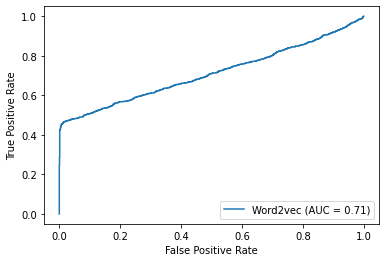

In [25]:
#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test[:3000], prevs_prob[:3000])

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.savefig(r'C:\Users\BeatrizCarvalho\Music\test1\roc_auc.png')
plt.show()

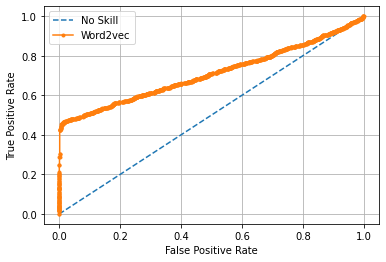

In [24]:
#roc curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test[:3000]))]

#roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_test[:3000], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test[:3000], prevs_prob[:3000])

#plot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Word2vec')

#axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

#legend
pyplot.legend()

#grid
pyplot.grid()

#save
plt.savefig(r'C:\Users\BeatrizCarvalho\Music\test1\roc.png')

pyplot.show()

In [26]:
#---------------------------------------------------density matrix------------------------------------------------------------#

#product of the matrices

#weight matrices
m1 = curr_model.wv.vectors
m2 = curr_model.syn1neg  #negative sampling
#m2 = model.syn1    #hierarchical-softmax 

mproduct = np.matmul(m1, m2.T)
mproduct.shape

(33561, 33561)

In [27]:
#apply softmax to obtain a matrix with conditional probabilities
conditional_probs = softmax(mproduct)

In [28]:
#visualize the 1st 20 lines and the last 20 lines of the density matrix

#1st 20 lines
conditional_aux = conditional_probs[:20].copy()

#last 20 lines
conditional_aux = np.concatenate((conditional_aux, conditional_probs[-20:].copy()))

In [29]:
#save density matrix - after the product and the softmax
pd.DataFrame(conditional_aux).to_csv(r'C:\Users\BeatrizCarvalho\Music\test1\density_matrix.csv', header = None, index = False)

In [30]:
#-------------------------------------------------eigenvalues-----------------------------------------------------------------#

#singular eingenvalues of the square matrix - after the product and before softmax - w has the eigenvalues and v the eigenvectors
w, v = np.linalg.eig(mproduct)  #mproduct is an array of arrays

#separate real and imaginary parts of the singular eigenvalues
x = w.real  #array

y = w.imag  #array

In [31]:
#save eigenvalues in csv
df = pd.DataFrame({"Real" : x, "Imaginary" : y})

df.to_csv(r'C:\Users\BeatrizCarvalho\Music\test1\eigenvalues.csv', index = False)